In [1]:
# import libraries
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
import zipfile
import requests

from io import StringIO, BytesIO
from statsmodels.regression.rolling import RollingOLS

warnings.filterwarnings('ignore')

In [2]:
# download S&P 500 data
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
headers = {'User-Agent': 'Mozilla/5.0'}

response = requests.get(url, headers=headers)
sp500 = pd.read_html(StringIO(response.text), flavor='html5lib')[0]

In [25]:
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2026-01-29'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                start=start_date,
                end=end_date, auto_adjust=False).stack()

[*********************100%***********************]  503 of 503 completed


In [26]:
df

Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2018-01-31 A        69.158569   73.430000   74.389999   73.239998   73.769997   
           AAPL     39.210728   41.857498   42.110001   41.625000   41.717499   
           ABBV     79.642006  112.220001  116.500000  111.290001  116.209999   
           ABNB           NaN         NaN         NaN         NaN         NaN   
           ABT      53.993217   62.160000   62.759998   61.849998   62.660000   
...                       ...         ...         ...         ...         ...   
2026-01-28 XYZ      64.220001   64.220001   65.919998   64.019997   65.000000   
           YUM     153.880005  153.880005  155.199997  153.279999  154.449997   
           ZBH      85.709999   85.709999   86.330002   84.910004   85.400002   
           ZBRA    236.229996  236.229996  240.809998  234.520004  240.490005   
           ZTS     121.930000  121.930000  125.089996  121.250000  124.029999   

Price                   Volume  
Date       Ticker               
2018-01-31 A         2032800.0  
           AAPL    129915600.0  
           ABBV     15744800.0  
           ABNB            NaN  
           ABT       7804400.0  
...                        ...  
2026-01-28 XYZ       4927500.0  
           YUM       1702700.0  
           ZBH       1746900.0  
           ZBRA       484400.0  
           ZTS       6130200.0  

[1010527 rows x 6 columns]

### Calculate features and technical indicators for each stock

$$
\text{German-Klass Volatility} = \frac{(\ln(\text{High})-\ln(\text{Low}))^{2}}{2} - (2\ln(2)-1)(\ln(\text{Adj Close})-\ln(\text{Open}))^{2}
$$

In [27]:
df['garman_klass_vol'] = (((np.log(df['High'])-np.log(df['Low']))**2)/2) - (2 * np.log(2)-1)*((np.log(df['Adj Close'])-np.log(df['Open']))**2)

df['rsi'] = df.groupby(level=1)['Close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['Adj Close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['Adj Close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['Adj Close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['High'], low=stock_data['Low'], close=stock_data['Close'], length=14)    
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:, 0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['Close'].apply(compute_macd)

df['dollar_volume'] = (df['Adj Close']*df['Volume'])/1e6

df

Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2018-01-31 A        69.158569   73.430000   74.389999   73.239998   73.769997   
           AAPL     39.210728   41.857498   42.110001   41.625000   41.717499   
           ABBV     79.642006  112.220001  116.500000  111.290001  116.209999   
           ABNB           NaN         NaN         NaN         NaN         NaN   
           ABT      53.993217   62.160000   62.759998   61.849998   62.660000   
...                       ...         ...         ...         ...         ...   
2026-01-28 XYZ      64.220001   64.220001   65.919998   64.019997   65.000000   
           YUM     153.880005  153.880005  155.199997  153.279999  154.449997   
           ZBH      85.709999   85.709999   86.330002   84.910004   85.400002   
           ZBRA    236.229996  236.229996  240.809998  234.520004  240.490005   
           ZTS     121.930000  121.930000  125.089996  121.250000  124.029999   

Price                   Volume  garman_klass_vol        rsi    bb_low  \
Date       Ticker                                                       
2018-01-31 A         2032800.0         -0.001488        NaN       NaN   
           AAPL    129915600.0         -0.001416        NaN       NaN   
           ABBV     15744800.0         -0.054107        NaN       NaN   
           ABNB            NaN               NaN        NaN       NaN   
           ABT       7804400.0         -0.008454        NaN       NaN   
...                        ...               ...        ...       ...   
2026-01-28 XYZ       4927500.0          0.000371  45.943954  4.140107   
           YUM       1702700.0          0.000072  51.963773  5.005001   
           ZBH       1746900.0          0.000132  38.791337  4.442315   
           ZBRA       484400.0          0.000227  40.394076  5.454023   
           ZTS       6130200.0          0.000373  43.026184  4.811534   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
Date       Ticker                                                         
2018-01-31 A            NaN       NaN       NaN       NaN     140.585540  
           AAPL         NaN       NaN       NaN       NaN    5094.085214  
           ABBV         NaN       NaN       NaN       NaN    1253.947455  
           ABNB         NaN       NaN       NaN       NaN            NaN  
           ABT          NaN       NaN       NaN       NaN     421.384666  
...                     ...       ...       ...       ...            ...  
2026-01-28 XYZ     4.213432  4.286756 -0.788191 -0.088825     316.444056  
           YUM     5.043787  5.082574  0.804060  0.249932     262.011484  
           ZBH     4.504518  4.566722 -0.606003 -0.622926     149.726797  
           ZBRA    5.523874  5.593726 -0.529641 -0.528915     114.429810  
           ZTS     4.837340  4.863145 -0.507250 -0.184029     747.455288  

[1010527 rows x 14 columns]

### Aggregate to monthly level and filter top 150 most liquid stocks for each month  
- To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [87]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'Volume',
                                                         'Open', 'High', 'Low', 'Close']]

data = (pd.concat([df.unstack('Ticker')['dollar_volume'].resample('ME').mean().stack('Ticker').to_frame('dollar_volume'),
          df.unstack()[last_cols].resample('ME').last().stack('Ticker')], 
          axis=1)).dropna()

calculate 5 year rolling overage of the stocks and filter out the top 150 most liquid stocks for each month

In [88]:
data

dollar_volume   Adj Close  garman_klass_vol        rsi  \
Date       Ticker                                                           
2018-03-31 A          150.151970   63.008427         -0.001044  37.194003   
           AAPL      5560.423991   39.452908         -0.001047  46.178650   
           ABBV       601.249350   67.172684         -0.044829  44.688290   
           ABT        357.841292   52.047527         -0.006877  45.942382   
           ACGL        78.126134   27.129135         -0.001026  47.735205   
...                          ...         ...               ...        ...   
2026-01-31 XYZ        412.882188   64.220001          0.000371  45.943954   
           YUM        305.907716  153.880005          0.000072  51.963773   
           ZBH        204.110928   85.709999          0.000132  38.791337   
           ZBRA       158.701075  236.229996          0.000227  40.394076   
           ZTS        576.450935  121.930000          0.000373  43.026184   

                     bb_low    bb_mid   bb_high       atr      macd  
Date       Ticker                                                    
2018-03-31 A       4.141273  4.186248  4.231223 -1.244657 -0.460699  
           AAPL    3.682333  3.737930  3.793527 -1.286165 -0.318770  
           ABBV    4.177355  4.362198  4.547042  1.396748 -2.425275  
           ABT     3.951064  3.997417  4.043770 -1.204394 -0.126408  
           ACGL    3.297965  3.341836  3.385706 -1.073146 -0.492283  
...                     ...       ...       ...       ...       ...  
2026-01-31 XYZ     4.140107  4.213432  4.286756 -0.788191 -0.088825  
           YUM     5.005001  5.043787  5.082574  0.804060  0.249932  
           ZBH     4.442315  4.504518  4.566722 -0.606003 -0.622926  
           ZBRA    5.454023  5.523874  5.593726 -0.529641 -0.528915  
           ZTS     4.811534  4.837340  4.863145 -0.507250 -0.184029  

[46810 rows x 9 columns]

In [61]:
data['dollar_volume'] = data.loc[:, 'dollar_volume'].unstack('Ticker').rolling(5*12).mean().stack()

data['dollar_volume_rank'] = data.groupby('Date')['dollar_volume'].rank(ascending=False)

data = data[data['dollar_volume_rank']<150].drop(['dollar_volume', 'dollar_volume_rank'], axis=1)

In [93]:
data.head()

dollar_volume  Adj Close  garman_klass_vol        rsi  \
Date       Ticker                                                          
2018-03-31 A          150.151970  63.008427         -0.001044  37.194003   
           AAPL      5560.423991  39.452908         -0.001047  46.178650   
           ABBV       601.249350  67.172684         -0.044829  44.688290   
           ABT        357.841292  52.047527         -0.006877  45.942382   
           ACGL        78.126134  27.129135         -0.001026  47.735205   

                     bb_low    bb_mid   bb_high       atr      macd  \
Date       Ticker                                                     
2018-03-31 A       4.141273  4.186248  4.231223 -1.244657 -0.460699   
           AAPL    3.682333  3.737930  3.793527 -1.286165 -0.318770   
           ABBV    4.177355  4.362198  4.547042  1.396748 -2.425275   
           ABT     3.951064  3.997417  4.043770 -1.204394 -0.126408   
           ACGL    3.297965  3.341836  3.385706 -1.073146 -0.492283   

                   dollar_volume_rank  
Date       Ticker                      
2018-03-31 A                    238.0  
           AAPL                   3.0  
           ABBV                  47.0  
           ABT                   86.0  
           ACGL                 376.0

### Calculating Monthly Returns for different time horizons as features  
- To capture time series dynamics hat reflect, for example momentum patterns, we compute historical returns using the method .pct_chante(lag), that is, returns over various monthly periods as identified by lags.
  

In [95]:
def calculate_returns(df):
    
    lags = [1, 2, 3, 6, 9, 12]
    
    outlier_cutoff = 0.005
    
    for lag in lags:
        df[f'return_{lag}m'] = (df['Adj Close']
                               .pct_change(lag)
                               .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                               .add(1)
                               .pow(1/lag)
                               .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

### Download Fama-French Factors and Calculate Rolling Factor Betas  
- We will introduce the Fama-French data to estimate the exposure of assets to common risk factors using linear regerssion.
- The five Fama-French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profits of portfolios. Hence, it is natural to include past factor exposures as financial features in models.
- We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression

In [100]:
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
headers = {'User-Agent': 'Mozilla/5.0'}
response = requests.get(url, headers=headers)

with zipfile.ZipFile(BytesIO(response.content)) as z:
    csv_name = z.namelist()[0]
    with z.open(csv_name) as f:
        data_text = f.read().decode('utf-8')
        monthly_data = data_text.split('\r\n\r\n')[1]

        ff_factors = pd.read_csv(StringIO(monthly_data))
        ff_factors.index = ff_factors['Unnamed: 0']
        ff_factors = ff_factors.drop('Unnamed: 0', axis=1)
        ff_factors.index.names = ['Date']
        ff_factors = ff_factors.loc['201803':, :]

        # we'll also drop RF for now
        ff_factors = ff_factors.drop('RF', axis=1)
        f.close()

ff_factors.head()

Mkt-RF   SMB   HML   RMW   CMA
Date                                  
201803   -2.35  3.61 -0.21 -0.41  0.08
201804    0.29  0.89  0.53 -2.42  1.24
201805    2.63  4.71 -3.14 -1.98 -1.49
201806    0.49  0.77 -2.33  0.83  0.20
201807    3.20 -1.93  0.49  1.53  0.31

In [141]:
factor_data = ff_factors.copy()

factor_data.index = pd.to_datetime(factor_data.index,format="%Y%m")

factor_data = factor_data.resample('ME').last().div(100)

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
Date       Ticker                                                   
2019-03-31 AAPL    0.0110 -0.0352 -0.0414  0.0088 -0.0090   0.097025
           ABBV    0.0110 -0.0352 -0.0414  0.0088 -0.0090   0.017037
           ABT     0.0110 -0.0352 -0.0414  0.0088 -0.0090   0.029889
           ACN     0.0110 -0.0352 -0.0414  0.0088 -0.0090   0.090718
           ADBE    0.0110 -0.0352 -0.0414  0.0088 -0.0090   0.015200
...                   ...     ...     ...     ...     ...        ...
2025-12-31 WDAY   -0.0036 -0.0022  0.0242  0.0040  0.0037  -0.003896
           WFC    -0.0036 -0.0022  0.0242  0.0040  0.0037   0.085614
           WMT    -0.0036 -0.0022  0.0242  0.0040  0.0037   0.010199
           XOM    -0.0036 -0.0022  0.0242  0.0040  0.0037   0.038130
           XYZ    -0.0036 -0.0022  0.0242  0.0040  0.0037  -0.025599

[11697 rows x 6 columns]

- Filter out stocks with less than 10 months of data

In [142]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('Ticker').isin(valid_stocks.index)]

In [143]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
Date       Ticker                                                   
2019-03-31 AAPL    0.0110 -0.0352 -0.0414  0.0088 -0.0090   0.097025
           ABBV    0.0110 -0.0352 -0.0414  0.0088 -0.0090   0.017037
           ABT     0.0110 -0.0352 -0.0414  0.0088 -0.0090   0.029889
           ACN     0.0110 -0.0352 -0.0414  0.0088 -0.0090   0.090718
           ADBE    0.0110 -0.0352 -0.0414  0.0088 -0.0090   0.015200
...                   ...     ...     ...     ...     ...        ...
2025-12-31 WDAY   -0.0036 -0.0022  0.0242  0.0040  0.0037  -0.003896
           WFC    -0.0036 -0.0022  0.0242  0.0040  0.0037   0.085614
           WMT    -0.0036 -0.0022  0.0242  0.0040  0.0037   0.010199
           XOM    -0.0036 -0.0022  0.0242  0.0040  0.0037   0.038130
           XYZ    -0.0036 -0.0022  0.0242  0.0040  0.0037  -0.025599

[11642 rows x 6 columns]

- Calculate Rolling Factor Betas:

In [146]:
betas = (factor_data.groupby(level=1,
                           group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m',axis=1)),
                                     window=min(24,x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)
        ))
betas

Mkt-RF       SMB       HML       RMW       CMA
Date       Ticker                                                  
2019-03-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-12-31 WDAY    0.535029 -0.563859 -0.125885 -1.130839  0.551250
           WFC     1.041920 -0.196265  0.667809 -1.384220  0.112610
           WMT     1.129760 -0.298300  0.358975  0.463814 -0.967169
           XOM     0.519607 -0.425260  1.229088 -0.016915  0.118671
           XYZ     1.127554  1.370030 -1.575628 -2.169121  0.624058

[11642 rows x 5 columns]

In [154]:
# data = data.join(betas.groupby('Ticker').shift())

# factors = ['Mkt-RF' 	, 'SMB' 	, 'HML' 	, 'RMW' 	, 'CMA']

# data.loc[:, factors] = data.groupby('Ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

# data = data.drop('Adj Close', axis=1)

# data = data.dropna()

data.info()

<class 'pandas.DataFrame'>
MultiIndex: 11537 entries, (Timestamp('2019-03-31 00:00:00'), 'AAPL') to (Timestamp('2026-01-31 00:00:00'), 'XYZ')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  11537 non-null  float64
 1   rsi               11537 non-null  float64
 2   bb_low            11537 non-null  float64
 3   bb_mid            11537 non-null  float64
 4   bb_high           11537 non-null  float64
 5   atr               11537 non-null  float64
 6   macd              11537 non-null  float64
 7   return_1m         11537 non-null  float64
 8   return_2m         11537 non-null  float64
 9   return_3m         11537 non-null  float64
 10  return_6m         11537 non-null  float64
 11  return_9m         11537 non-null  float64
 12  return_12m        11537 non-null  float64
 13  Mkt-RF            11537 non-null  float64
 14  SMB               11537 non-null  float64
 15  HML               115

#### At this point we have to decide on what ML model and approach to use for predictions etc.


### For each month fit a K-Means Clustering Algorithm to group similar assets based on their features  

#### K-Means Clusetering  
- You may want to initialise predefined centroids for each cluster based on your research.
- For visualisation purpose of this tutorial we will initially rely on the 'k-means++' initialisation.
- Then we will pre-define our centroids for each cluster.  

In [156]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4, # we take 4 here because the guy in the video has done his research beforehand, no information on any of that has been provided
                           random_state=0,
                           init='random').fit(df).labels_
    return df

data = data.dropna().groupby('Date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
Date       Ticker                                                              
2019-03-31 AAPL           -0.000767  63.679479  3.731288  3.802865  3.874442   
           ABBV           -0.033157  49.893166  4.066967  4.094684  4.122402   
           ABT            -0.005673  61.472956  4.231301  4.256732  4.282162   
           ACN            -0.003500  74.386309  4.973216  5.017511  5.061807   
           ADBE            0.000040  58.172454  5.538778  5.567821  5.596863   
...                             ...        ...       ...       ...       ...   
2026-01-31 WDAY            0.000303  34.558995  5.182877  5.296347  5.409818   
           WFC             0.000301  44.613909  4.444182  4.525876  4.607570   
           WMT             0.000093  55.614033  4.712444  4.764208  4.815972   
           XOM             0.000047  72.772862  4.765239  4.858060  4.950881   
           XYZ             0.000371  45.943954  4.140107  4.213432  4.286756   

                        atr      macd  return_1m  return_2m  return_3m  \
Date       Ticker                                                        
2019-03-31 AAPL   -1.371270  0.145650   0.097025   0.070582   0.065415   
           ABBV   -1.246684 -0.172722   0.017037   0.001866  -0.039943   
           ABT    -1.212117  0.565680   0.029889   0.046599   0.035504   
           ACN    -1.259432  0.569502   0.090718   0.070671   0.076723   
           ADBE   -1.338931  0.181358   0.015200   0.036985   0.056097   
...                     ...       ...        ...        ...        ...   
2026-01-31 WDAY   -0.694749 -1.679596  -0.119471  -0.063465  -0.076245   
           WFC     1.701118 -1.142930  -0.055472   0.012617   0.005803   
           WMT     2.548864  1.367221   0.046315   0.028099   0.049040   
           XOM     0.710776  2.949158   0.143261   0.089428   0.066648   
           XYZ    -0.788191 -0.088825  -0.013366  -0.019502  -0.054344   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
Date       Ticker                                                         
2019-03-31 AAPL    -0.027103   0.004128    0.011669  1.186875 -0.051634   
           ABBV    -0.022614  -0.011759   -0.009745  0.526313  0.068965   
           ABT      0.015896   0.032034    0.025852  0.797028 -0.159188   
           ACN      0.007146   0.009190    0.012982  1.121549 -0.128368   
           ADBE    -0.002148   0.009932    0.017628  1.398108 -0.627791   
...                      ...        ...         ...       ...       ...   
2026-01-31 WDAY    -0.031655  -0.028354   -0.026817  1.147238 -0.511726   
           WFC      0.016621   0.026048    0.011083  1.039862 -0.152005   
           WMT      0.030128   0.021108    0.015233  0.663856 -0.255810   
           XOM      0.038540   0.032908    0.024377  0.867695 -0.073530   
           XYZ     -0.030340   0.010477   -0.028467  2.346041  0.432952   

                        HML       RMW       CMA  cluster  
Date       Ticker                                         
2019-03-31 AAPL   -0.600729  0.447354  0.332682        2  
           ABBV    0.117778  0.231325  0.551067        3  
           ABT    -0.186530 -0.088012  0.904859        2  
           ACN    -0.203467  0.151250 -0.113032        0  
           ADBE   -0.141425  0.346141 -0.425805        2  
...                     ...       ...       ...      ...  
2026-01-31 WDAY   -0.223046 -0.802685 -0.565758        2  
           WFC     1.426835 -0.941977 -0.900909        3  
           WMT    -0.324937  0.277325  0.375753        1  
           XOM     0.918045 -0.221247  0.325132        0  
           XYZ    -0.128437 -2.305352 -0.317502        3  

[11537 rows x 19 columns]

In [157]:
def plot_clusters(data):
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5], cluster_0.iloc[:,1], color='red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5], cluster_1.iloc[:,1], color='green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5], cluster_2.iloc[:,1], color='blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5], cluster_3.iloc[:,1], color='black', label='cluster 3')

    plt.legend()
    plt.show()
    return

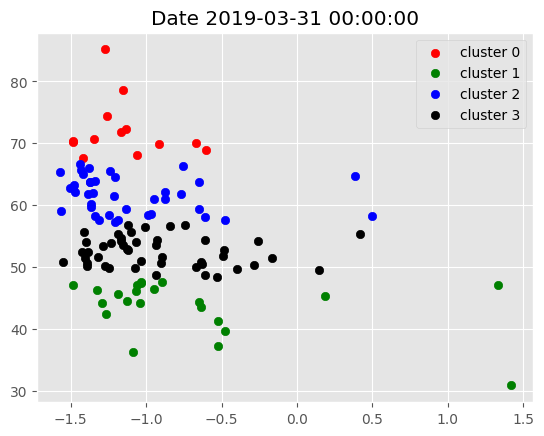

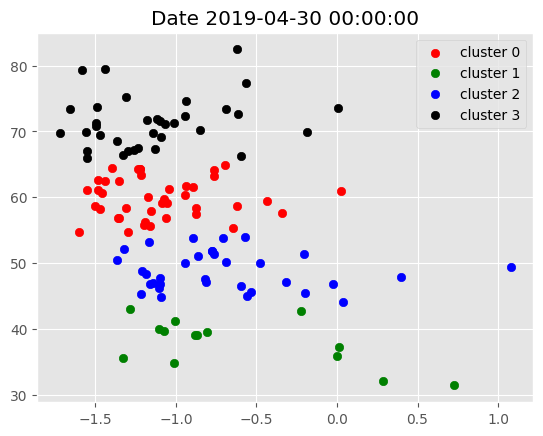

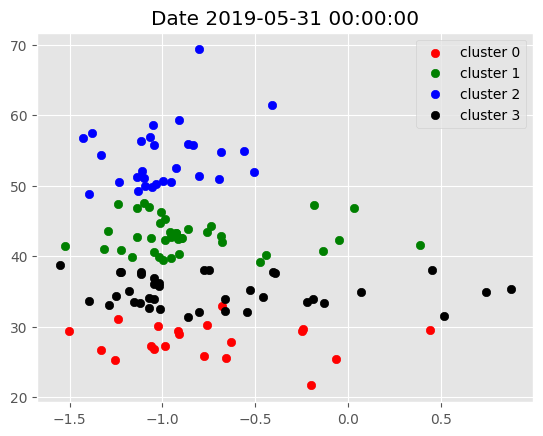

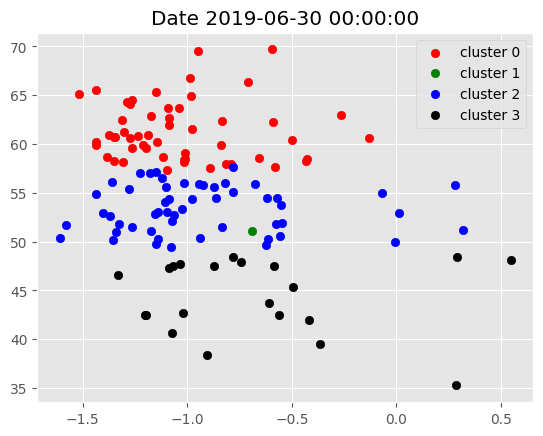

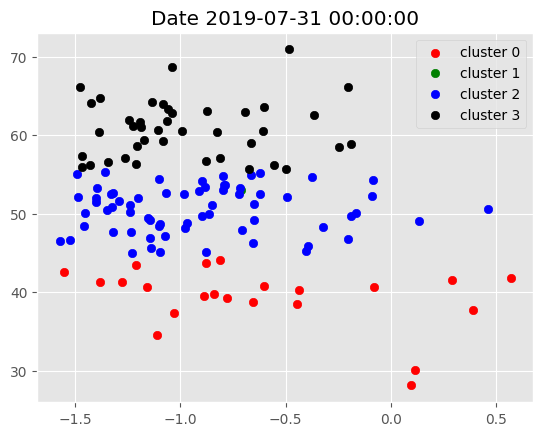

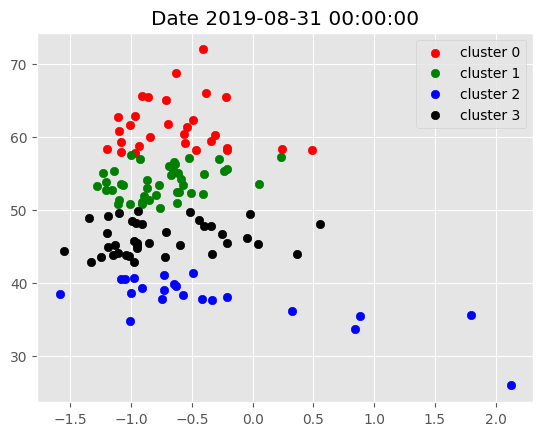

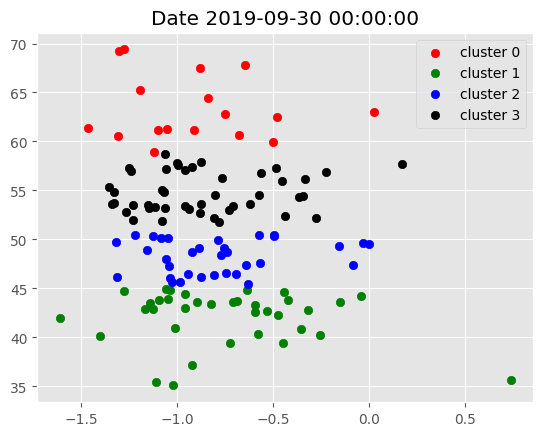

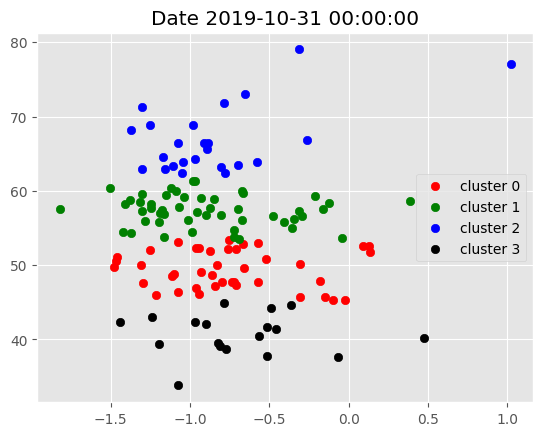

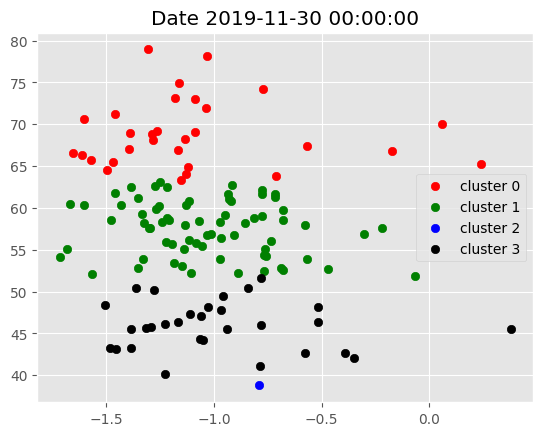

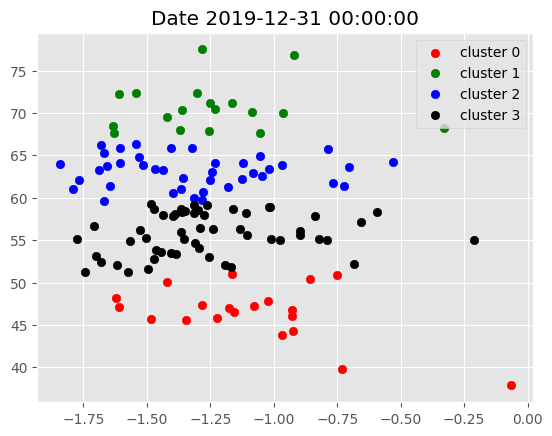

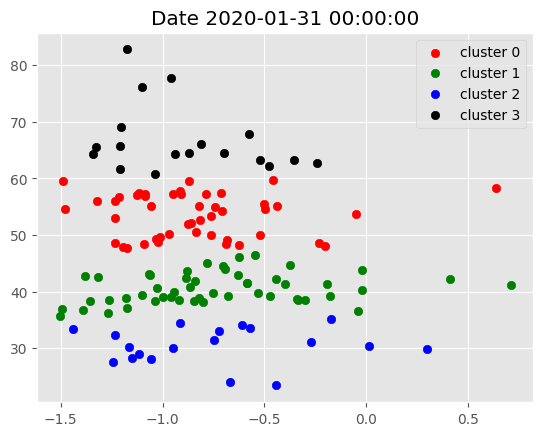

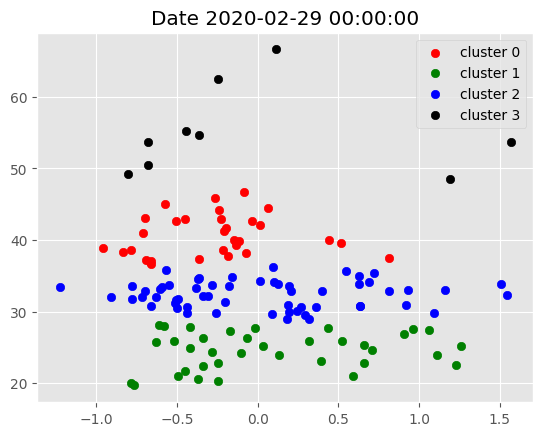

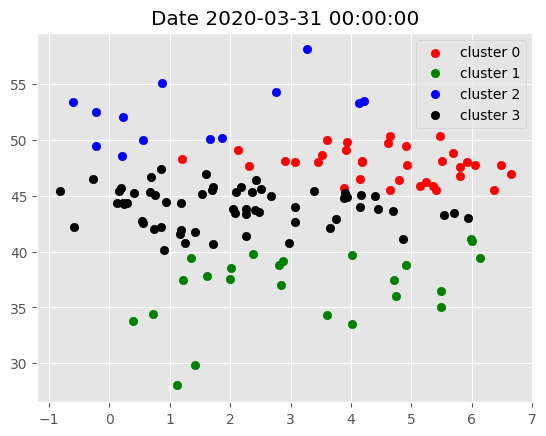

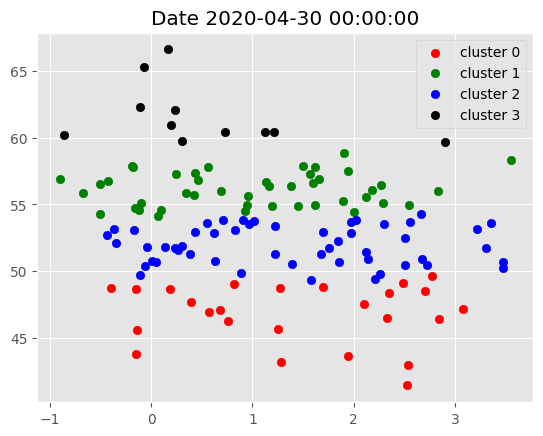

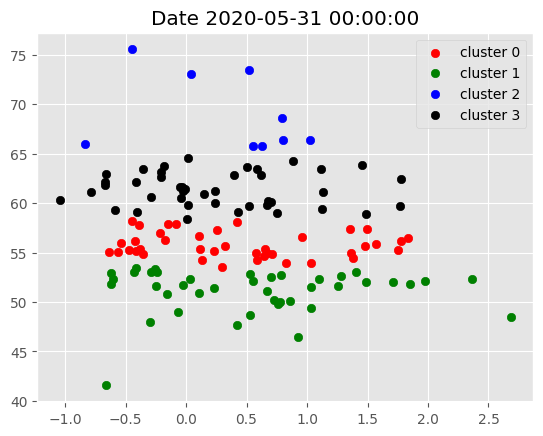

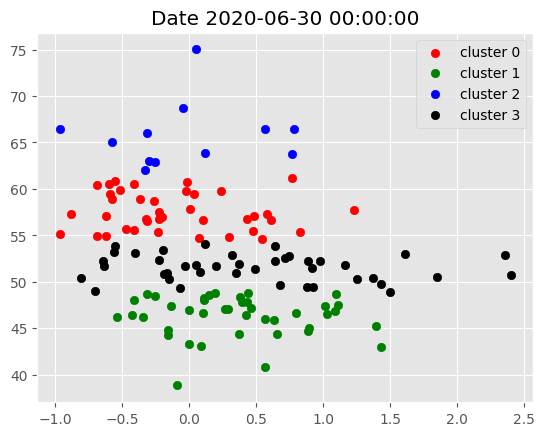

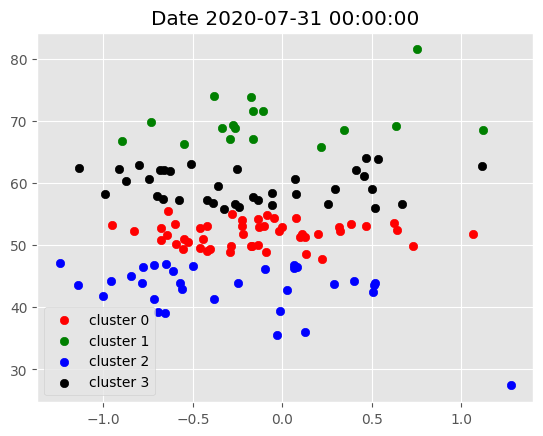

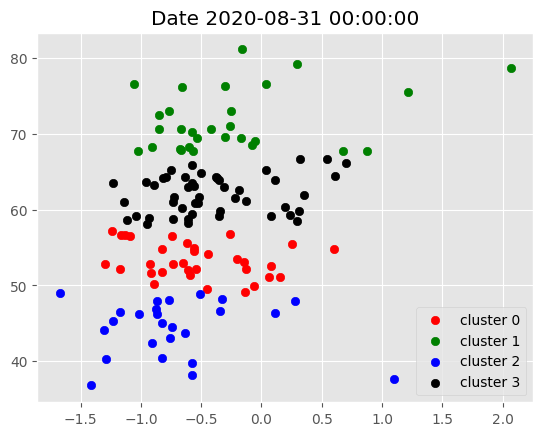

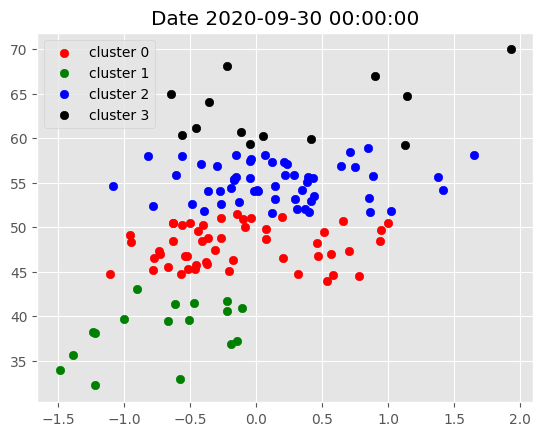

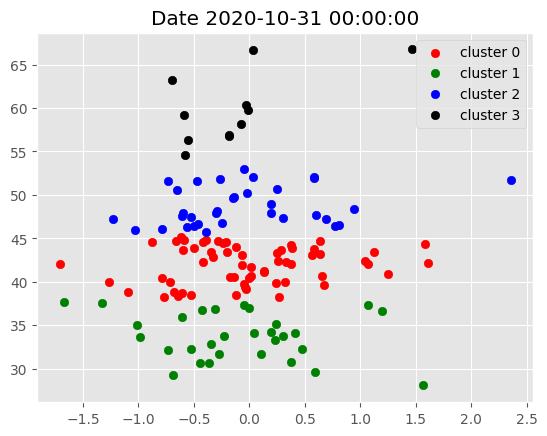

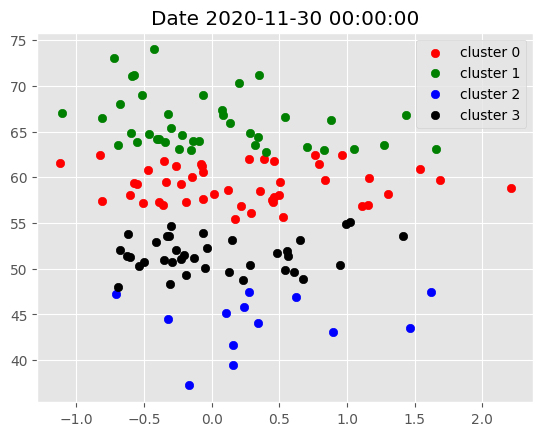

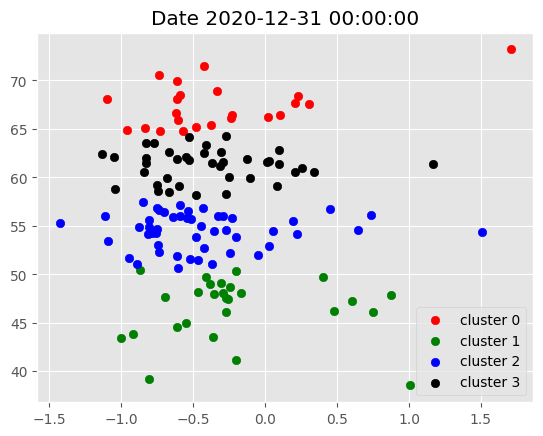

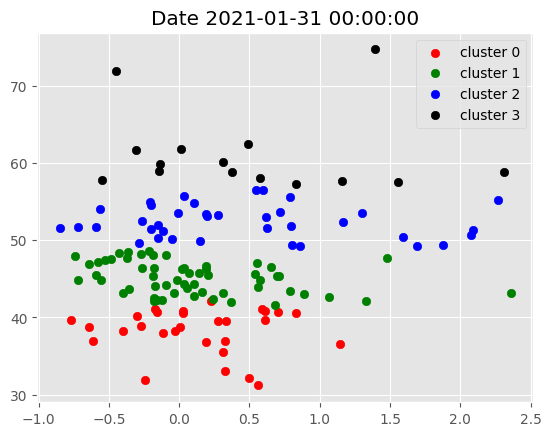

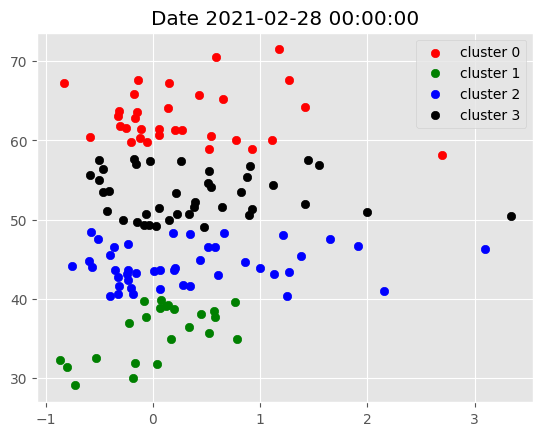

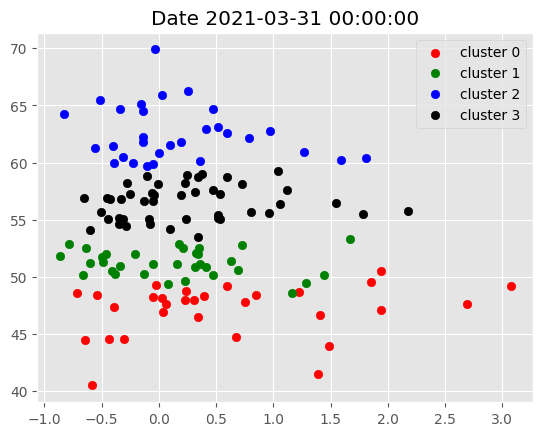

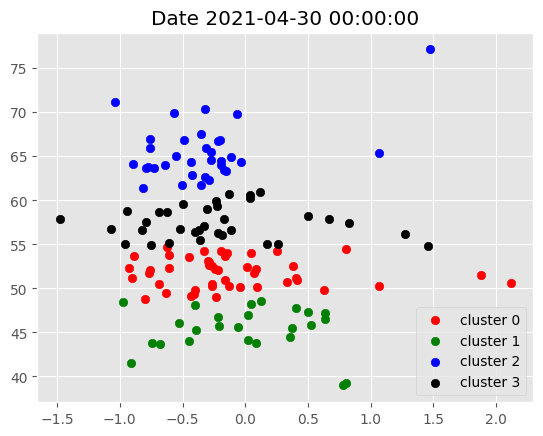

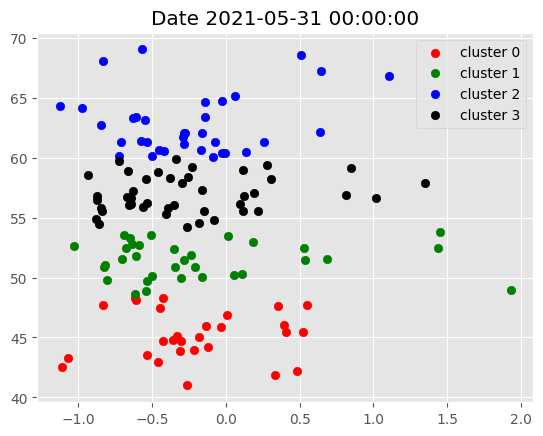

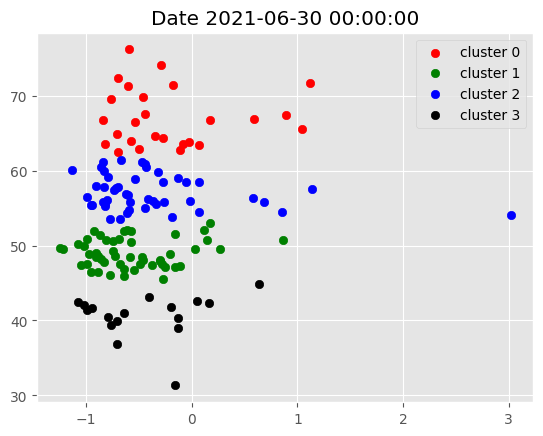

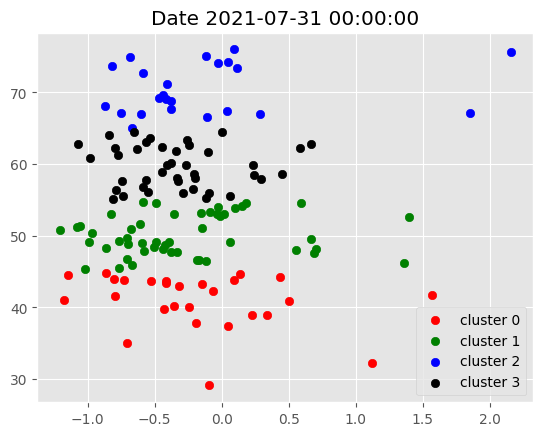

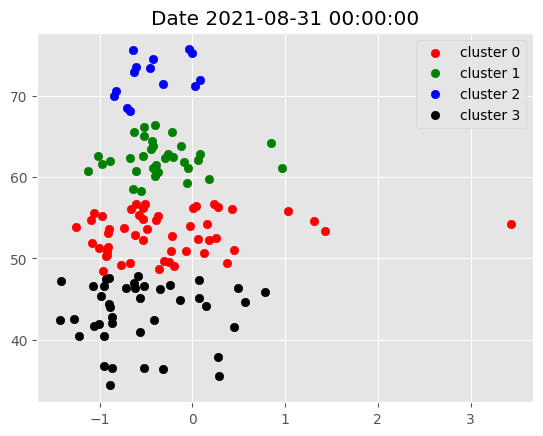

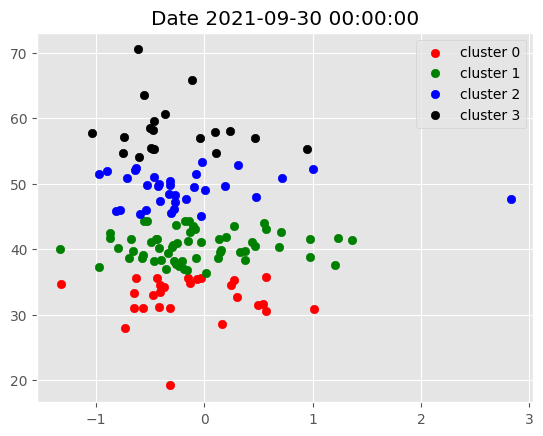

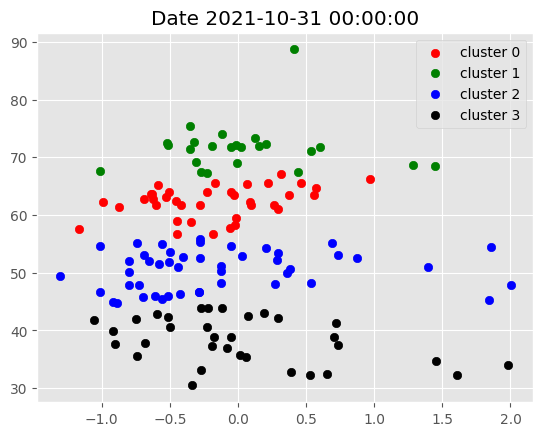

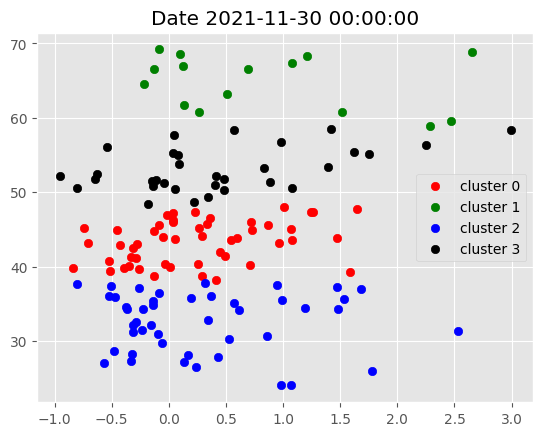

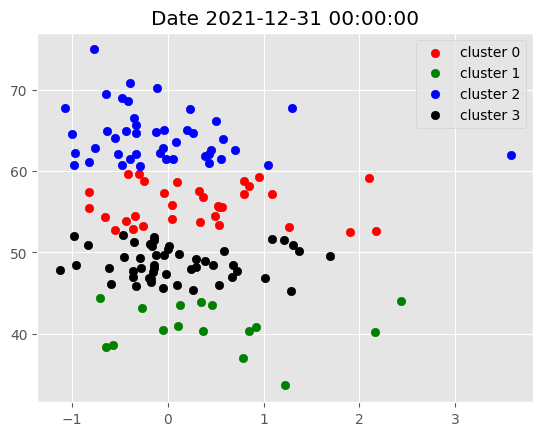

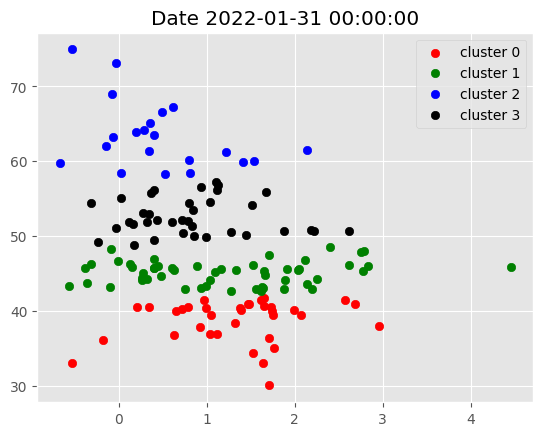

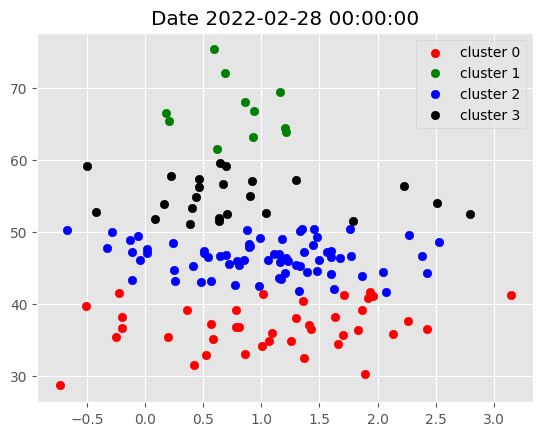

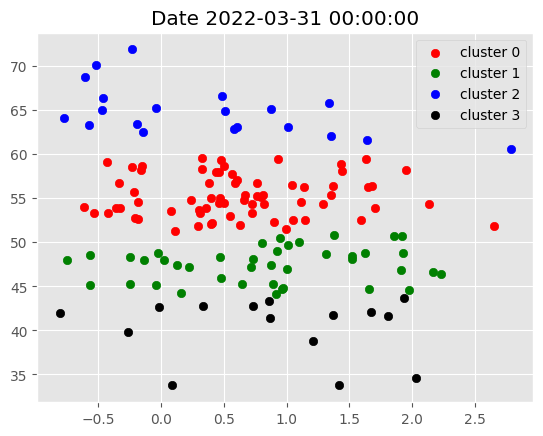

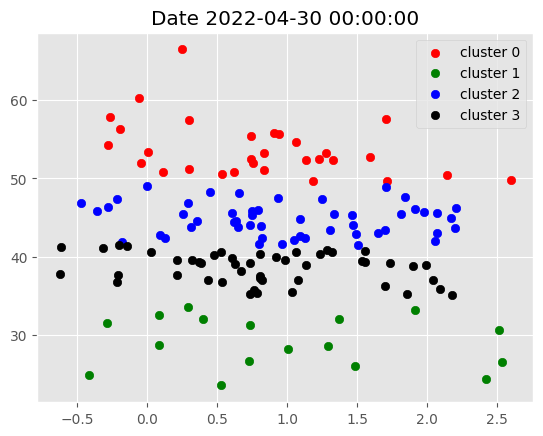

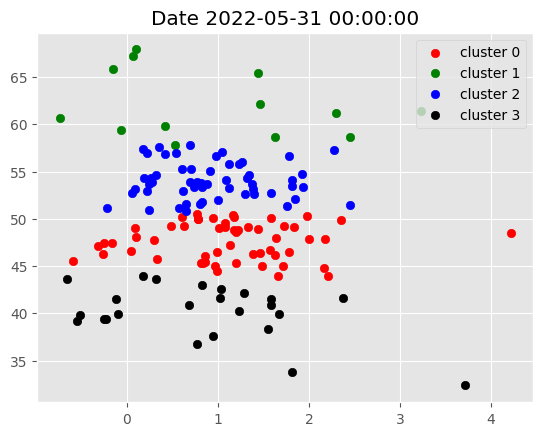

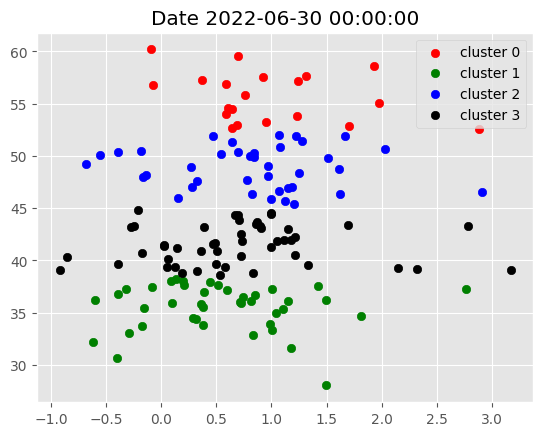

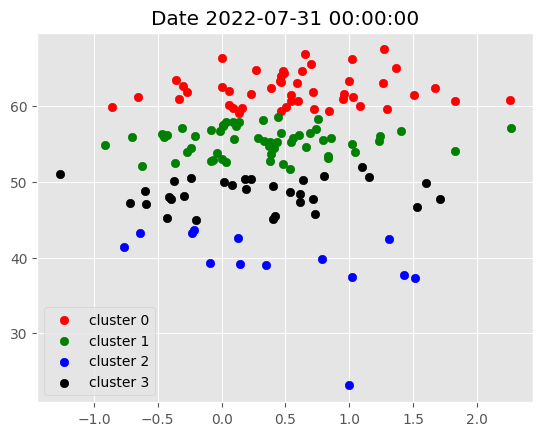

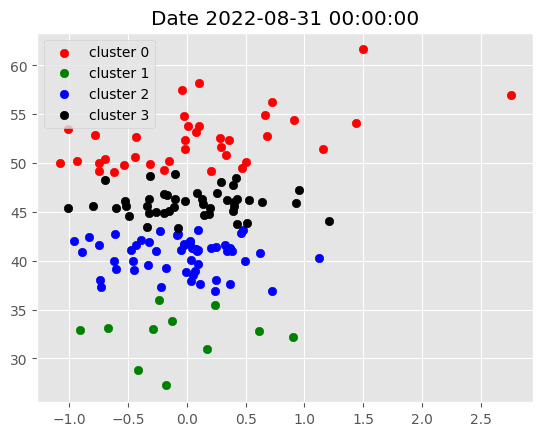

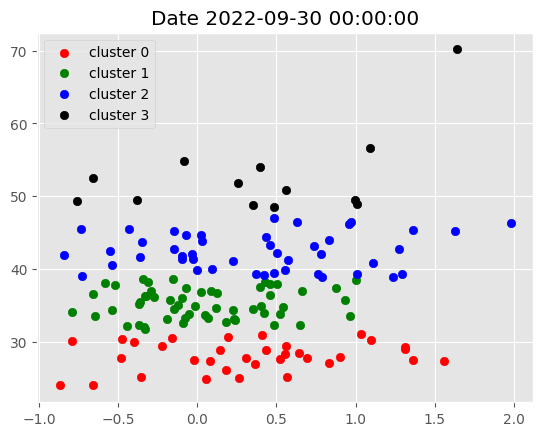

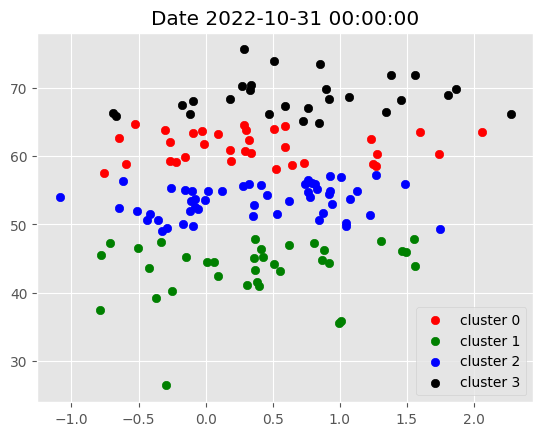

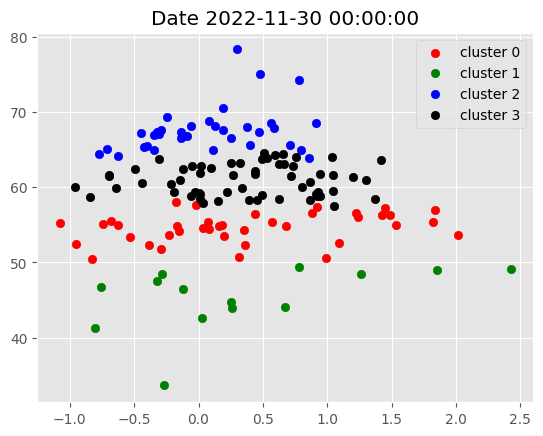

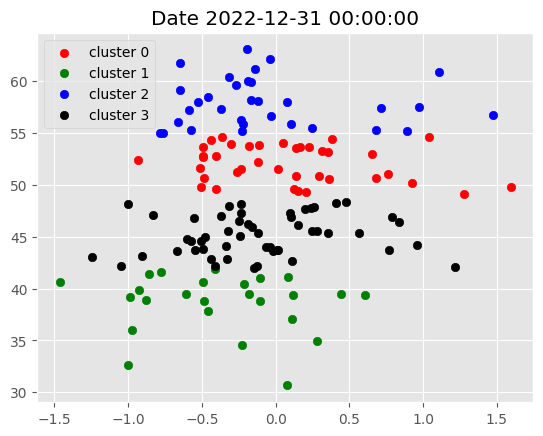

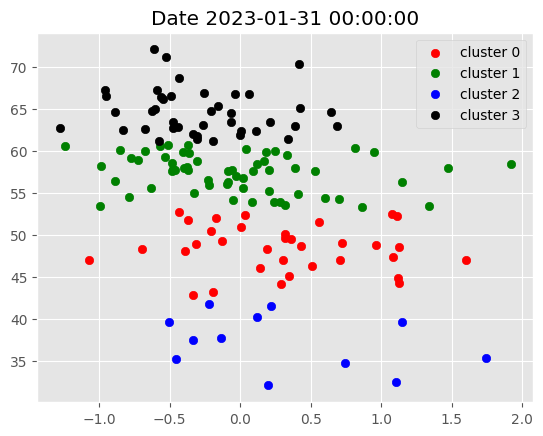

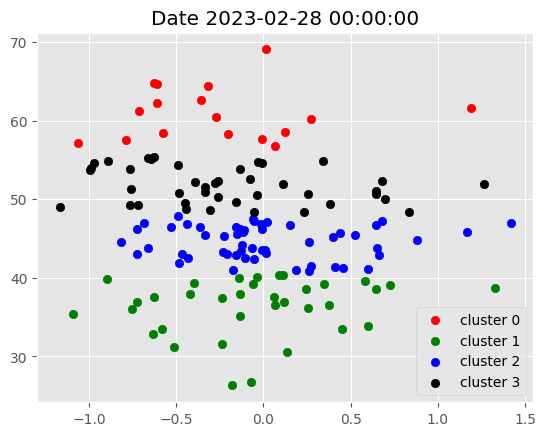

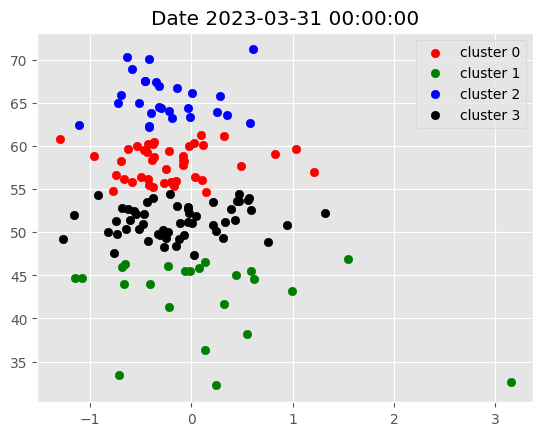

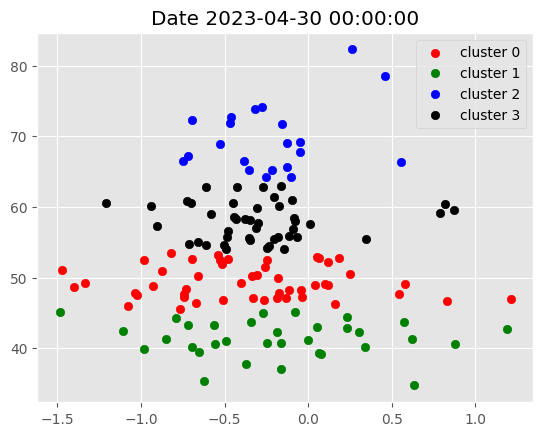

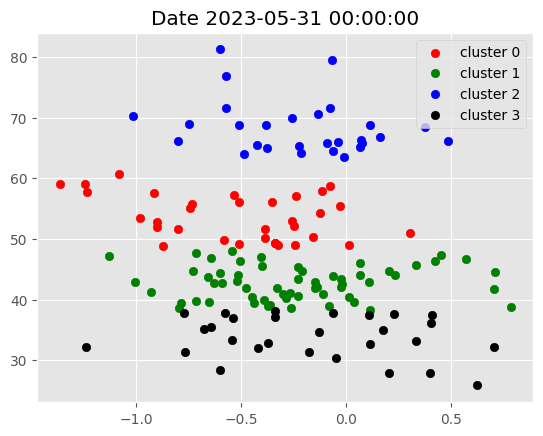

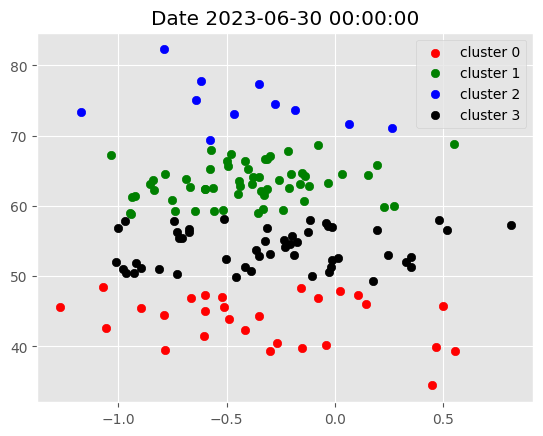

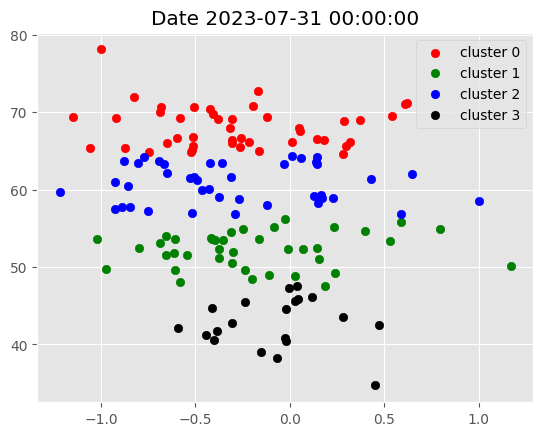

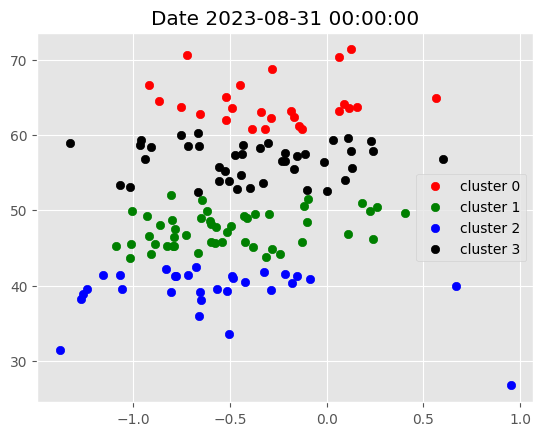

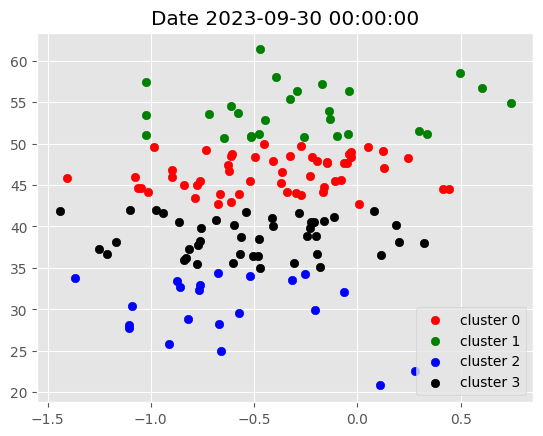

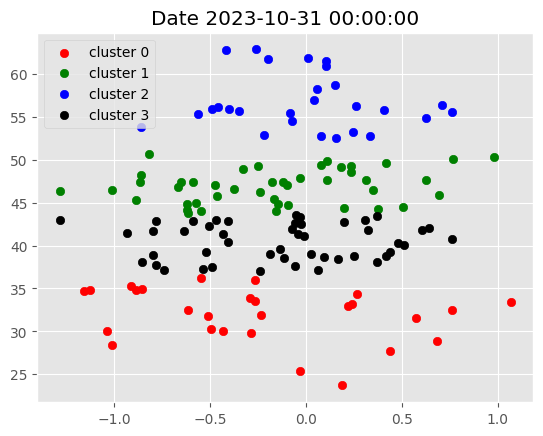

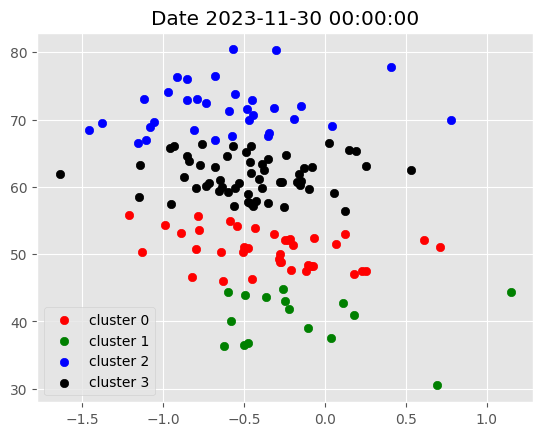

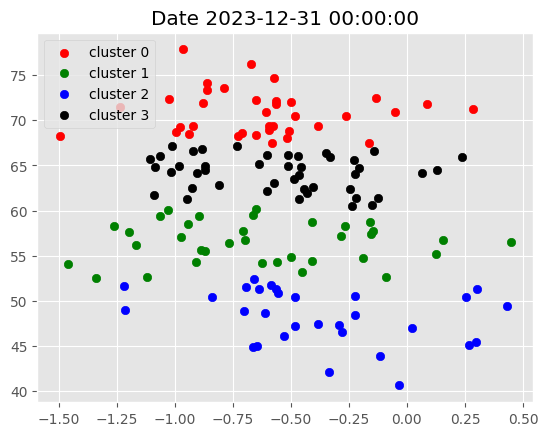

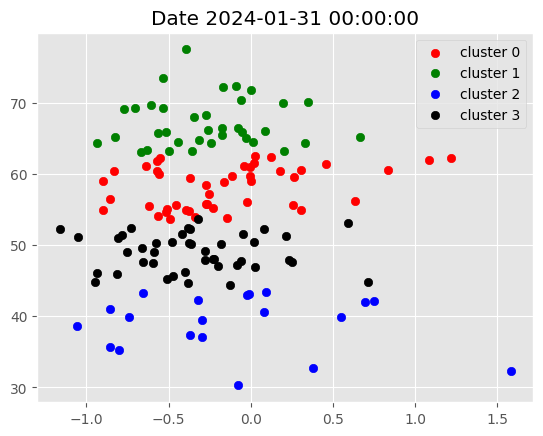

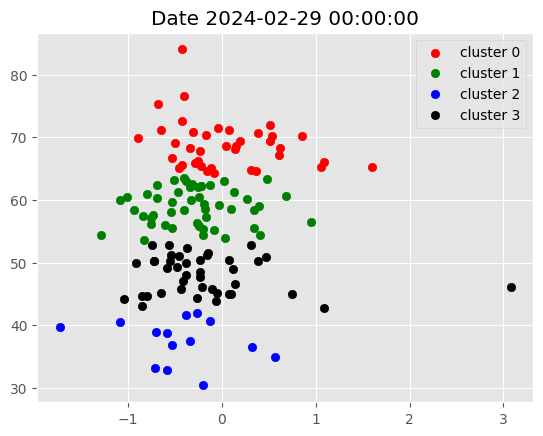

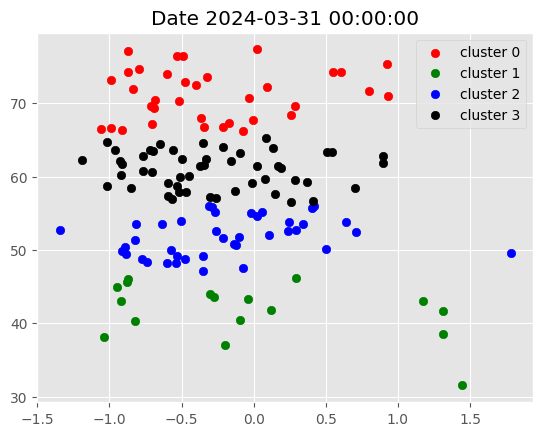

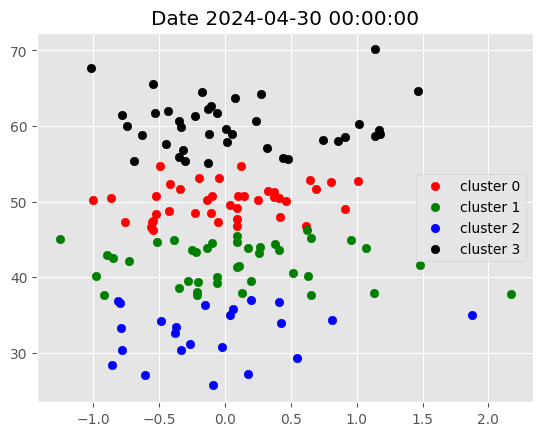

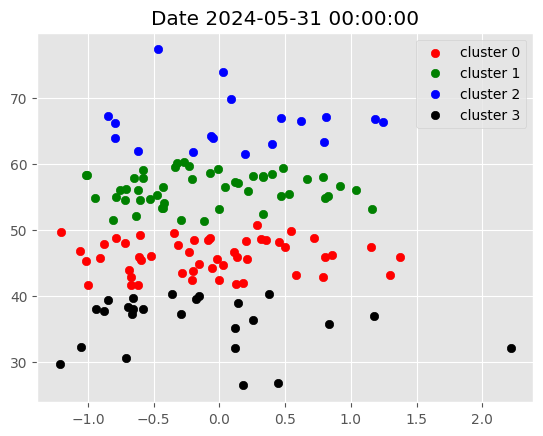

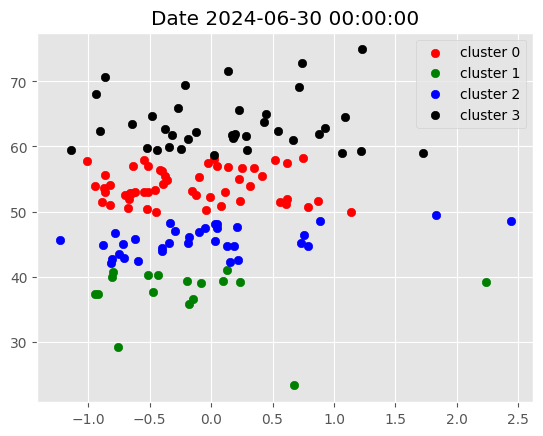

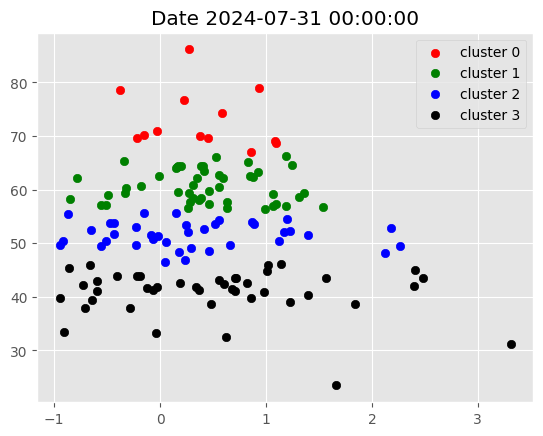

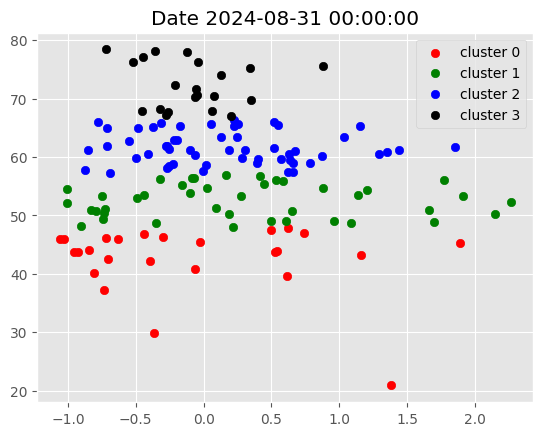

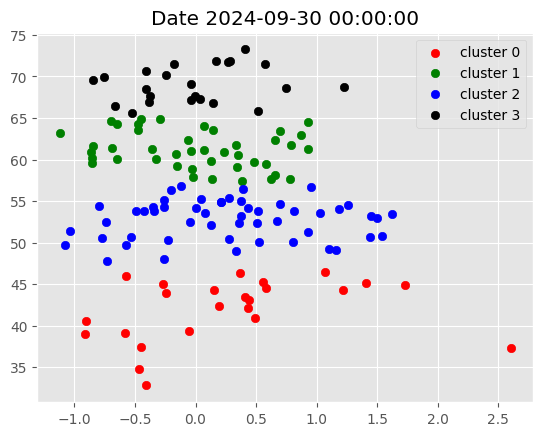

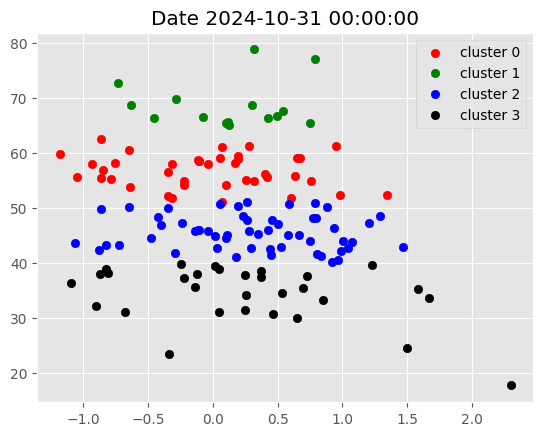

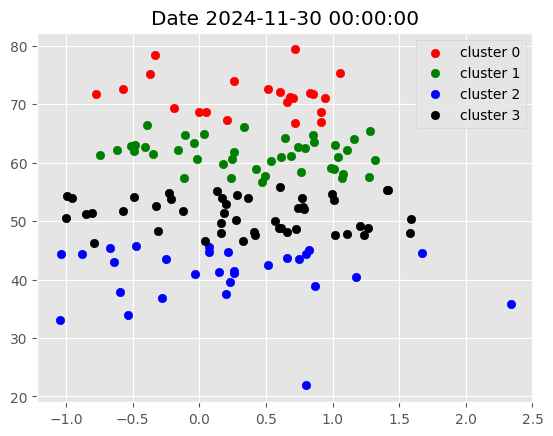

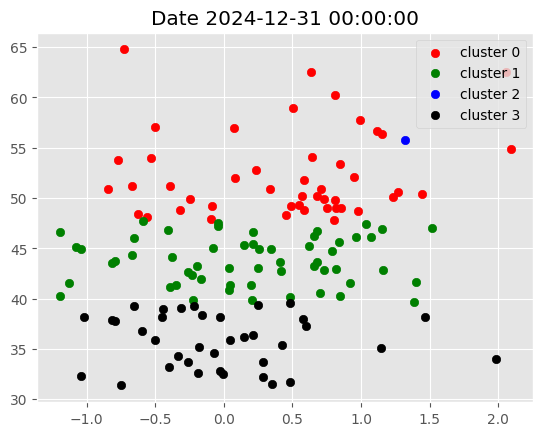

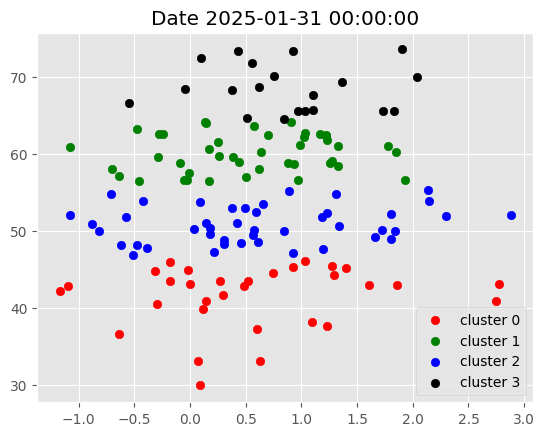

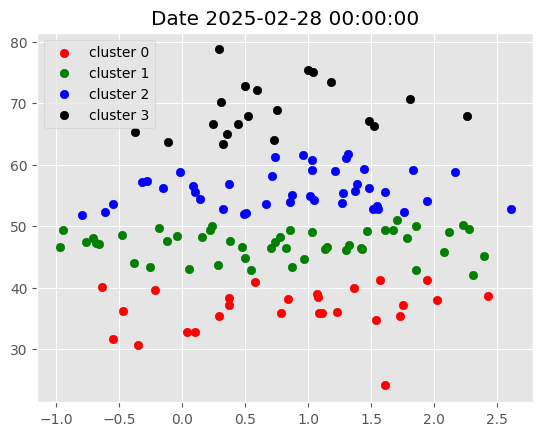

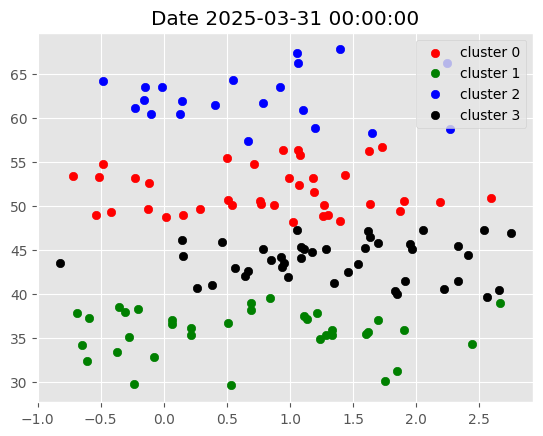

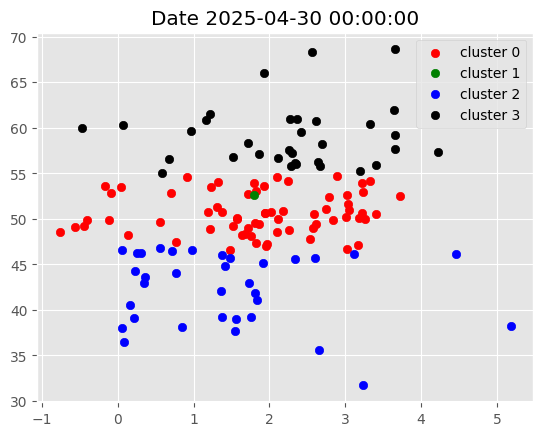

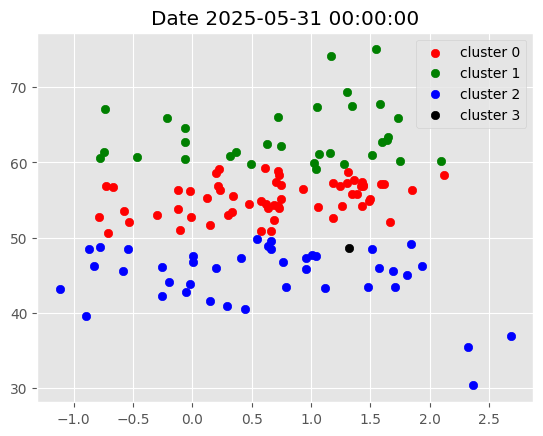

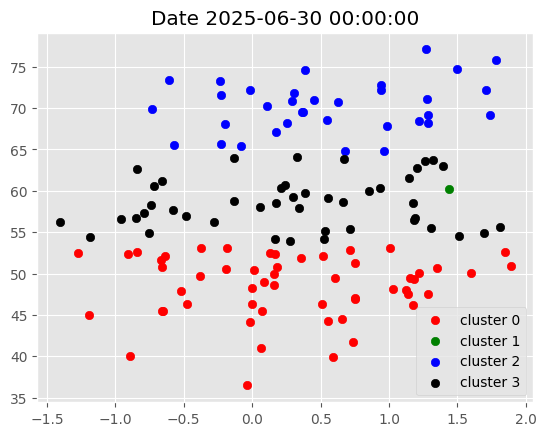

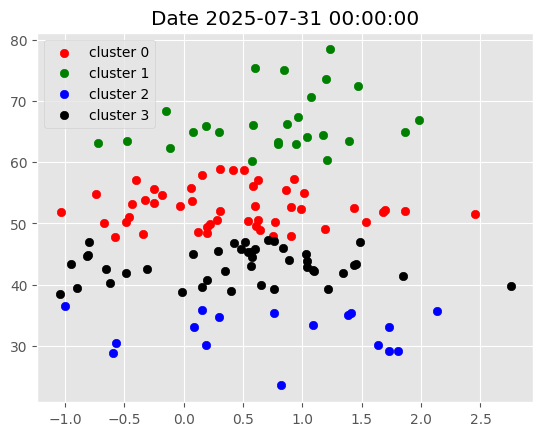

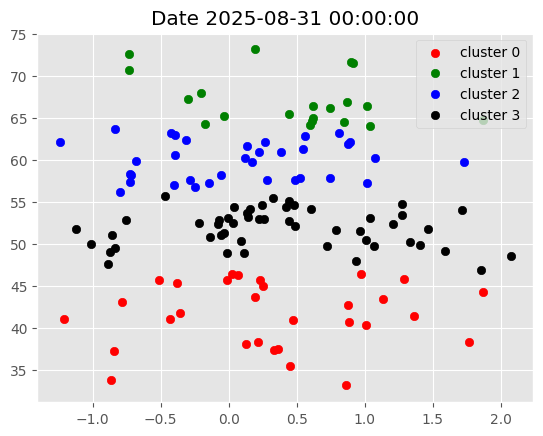

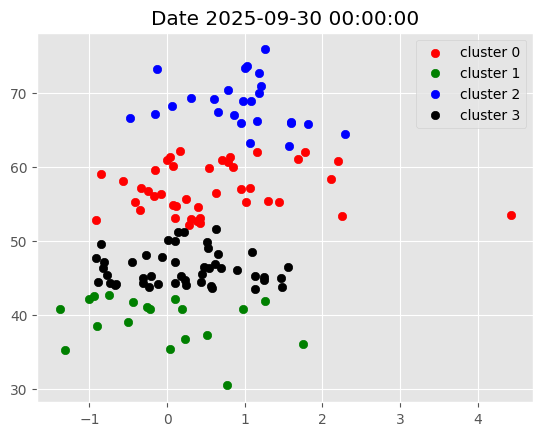

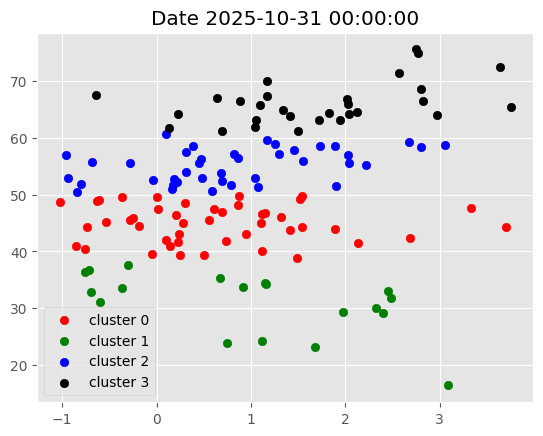

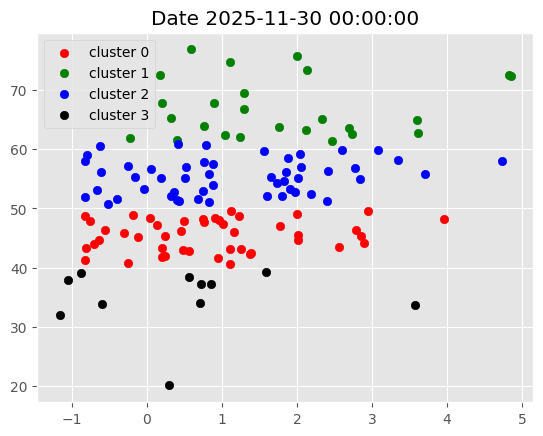

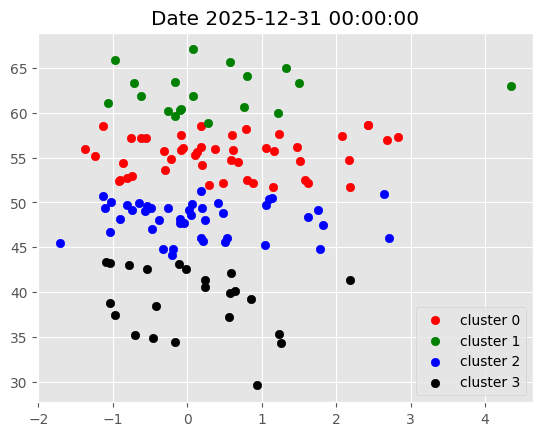

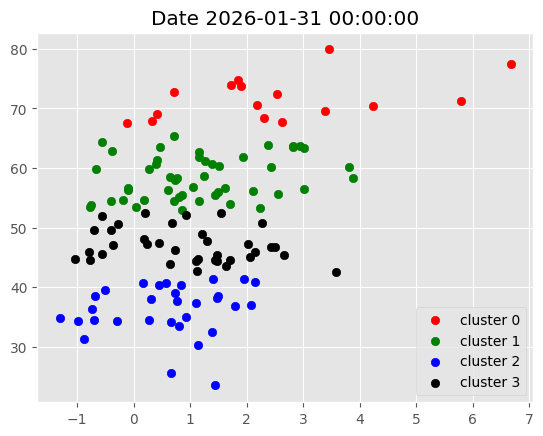

In [158]:
plt.style.use('ggplot')

for i in data.index.get_level_values('Date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')
    
    plot_clusters(g)

#### Supply predefined centroids

In [170]:
data = data.drop('cluster', axis=1) # reset clusters to start again, this time not taking random initial centroids

target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), len(data.columns)))

initial_centroids[:, 1] = target_rsi_values

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4, # we take 4 here because the guy in the video has done his research beforehand, no information on any of that has been provided
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('Date', group_keys=False).apply(get_clusters)

In [172]:
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
Date       Ticker                                                              
2019-03-31 AAPL           -0.000767  63.679479  3.731288  3.802865  3.874442   
           ABBV           -0.033157  49.893166  4.066967  4.094684  4.122402   
           ABT            -0.005673  61.472956  4.231301  4.256732  4.282162   
           ACN            -0.003500  74.386309  4.973216  5.017511  5.061807   
           ADBE            0.000040  58.172454  5.538778  5.567821  5.596863   
...                             ...        ...       ...       ...       ...   
2026-01-31 WDAY            0.000303  34.558995  5.182877  5.296347  5.409818   
           WFC             0.000301  44.613909  4.444182  4.525876  4.607570   
           WMT             0.000093  55.614033  4.712444  4.764208  4.815972   
           XOM             0.000047  72.772862  4.765239  4.858060  4.950881   
           XYZ             0.000371  45.943954  4.140107  4.213432  4.286756   

                        atr      macd  return_1m  return_2m  return_3m  \
Date       Ticker                                                        
2019-03-31 AAPL   -1.371270  0.145650   0.097025   0.070582   0.065415   
           ABBV   -1.246684 -0.172722   0.017037   0.001866  -0.039943   
           ABT    -1.212117  0.565680   0.029889   0.046599   0.035504   
           ACN    -1.259432  0.569502   0.090718   0.070671   0.076723   
           ADBE   -1.338931  0.181358   0.015200   0.036985   0.056097   
...                     ...       ...        ...        ...        ...   
2026-01-31 WDAY   -0.694749 -1.679596  -0.119471  -0.063465  -0.076245   
           WFC     1.701118 -1.142930  -0.055472   0.012617   0.005803   
           WMT     2.548864  1.367221   0.046315   0.028099   0.049040   
           XOM     0.710776  2.949158   0.143261   0.089428   0.066648   
           XYZ    -0.788191 -0.088825  -0.013366  -0.019502  -0.054344   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
Date       Ticker                                                         
2019-03-31 AAPL    -0.027103   0.004128    0.011669  1.186875 -0.051634   
           ABBV    -0.022614  -0.011759   -0.009745  0.526313  0.068965   
           ABT      0.015896   0.032034    0.025852  0.797028 -0.159188   
           ACN      0.007146   0.009190    0.012982  1.121549 -0.128368   
           ADBE    -0.002148   0.009932    0.017628  1.398108 -0.627791   
...                      ...        ...         ...       ...       ...   
2026-01-31 WDAY    -0.031655  -0.028354   -0.026817  1.147238 -0.511726   
           WFC      0.016621   0.026048    0.011083  1.039862 -0.152005   
           WMT      0.030128   0.021108    0.015233  0.663856 -0.255810   
           XOM      0.038540   0.032908    0.024377  0.867695 -0.073530   
           XYZ     -0.030340   0.010477   -0.028467  2.346041  0.432952   

                        HML       RMW       CMA  cluster  
Date       Ticker                                         
2019-03-31 AAPL   -0.600729  0.447354  0.332682        3  
           ABBV    0.117778  0.231325  0.551067        1  
           ABT    -0.186530 -0.088012  0.904859        2  
           ACN    -0.203467  0.151250 -0.113032        3  
           ADBE   -0.141425  0.346141 -0.425805        2  
...                     ...       ...       ...      ...  
2026-01-31 WDAY   -0.223046 -0.802685 -0.565758        0  
           WFC     1.426835 -0.941977 -0.900909        1  
           WMT    -0.324937  0.277325  0.375753        2  
           XOM     0.918045 -0.221247  0.325132        3  
           XYZ    -0.128437 -2.305352 -0.317502        1  

[11537 rows x 19 columns]

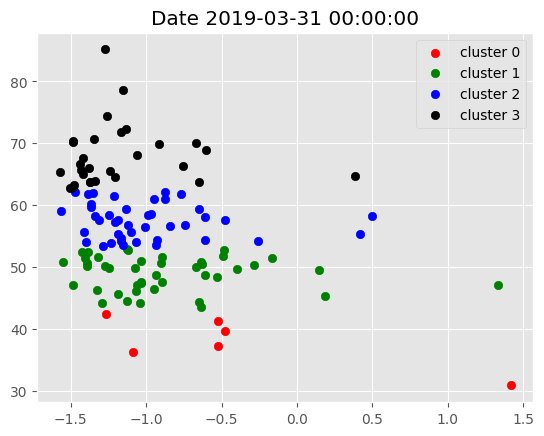

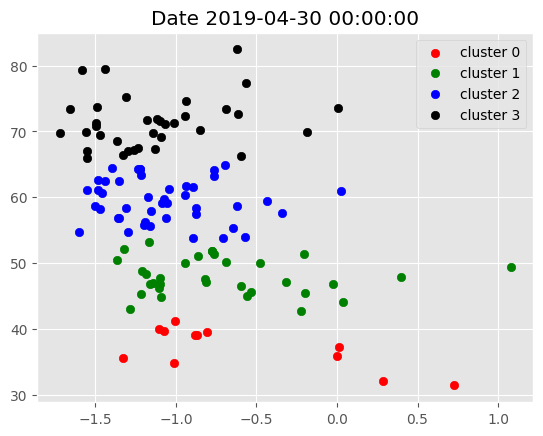

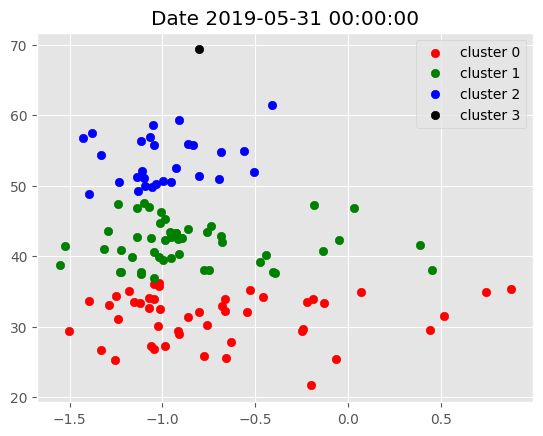

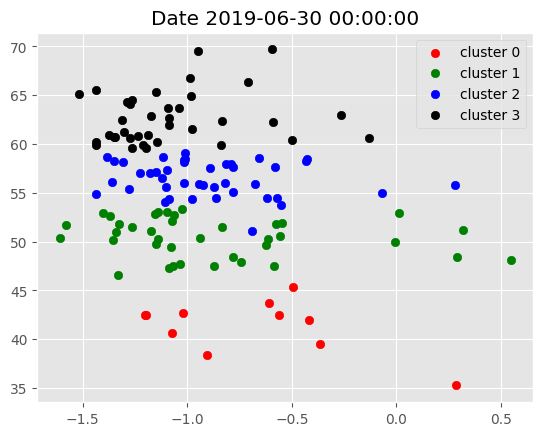

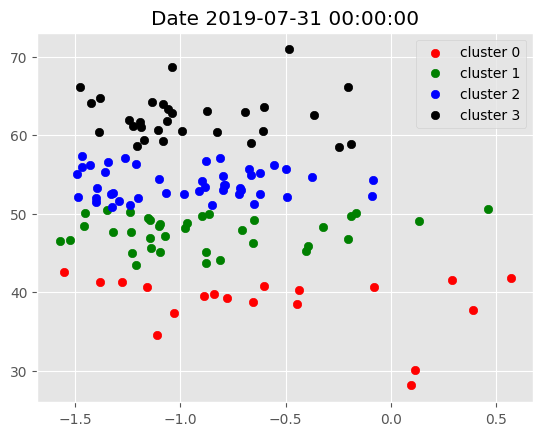

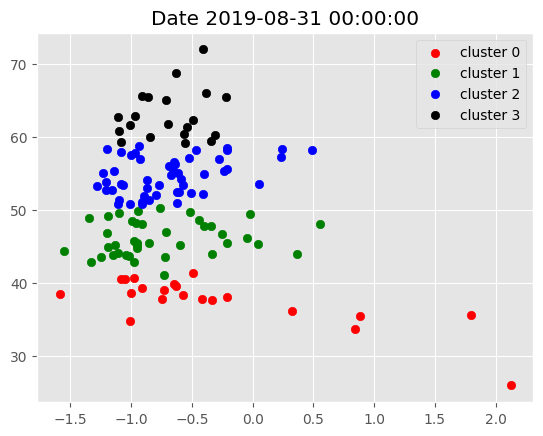

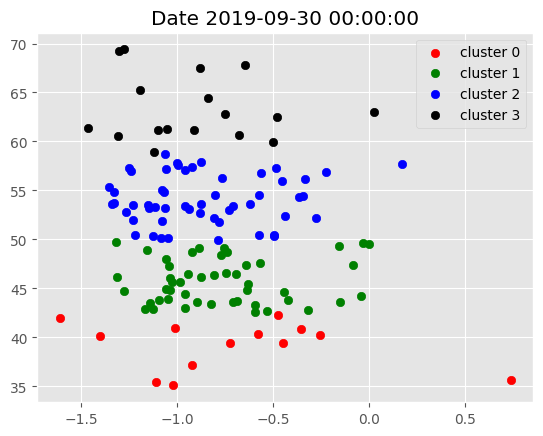

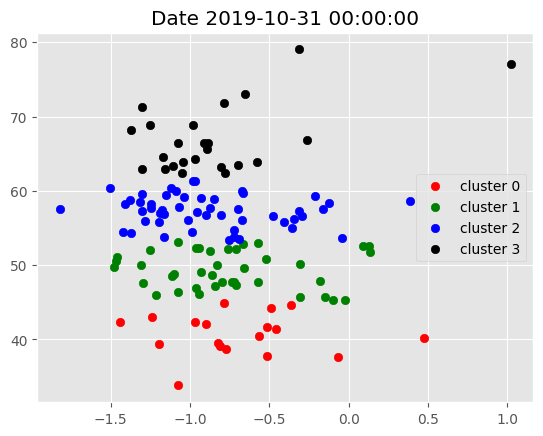

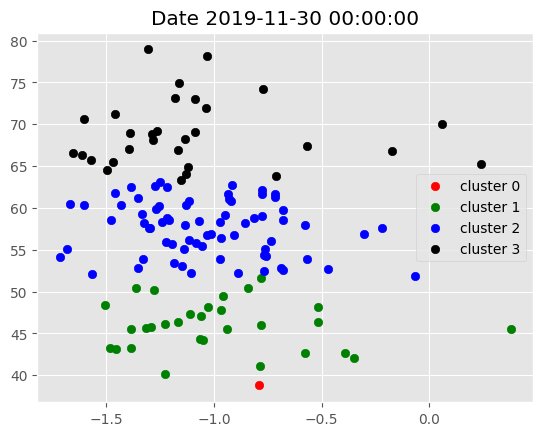

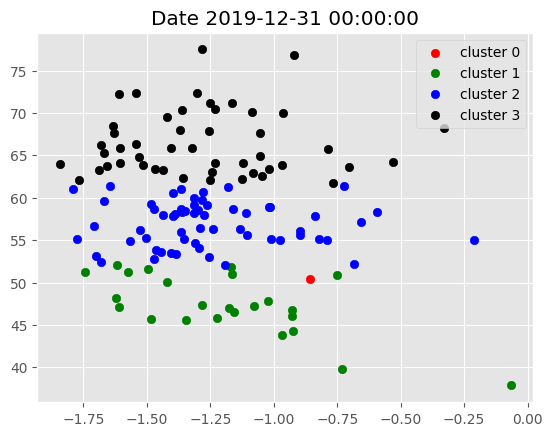

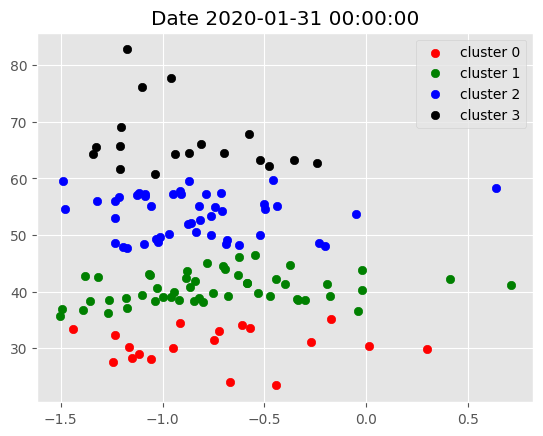

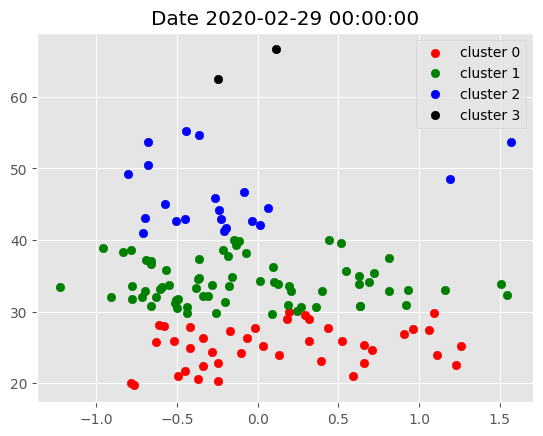

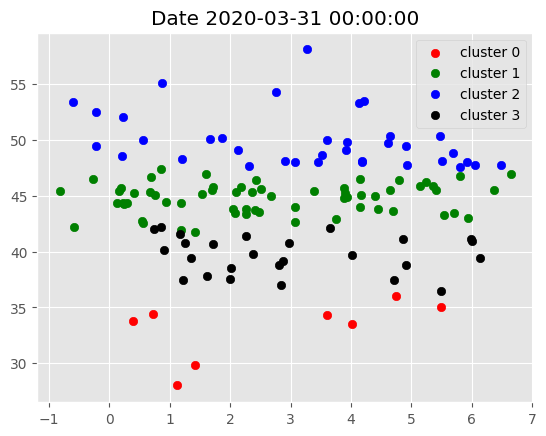

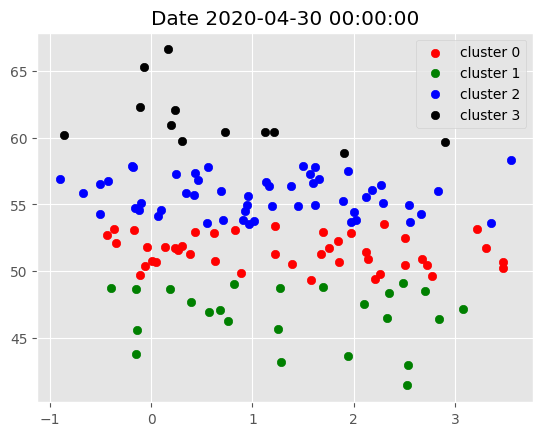

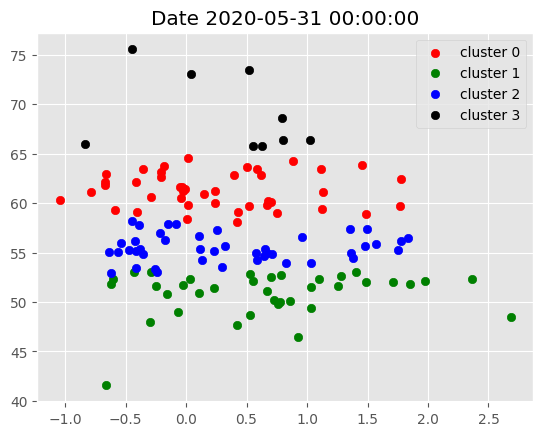

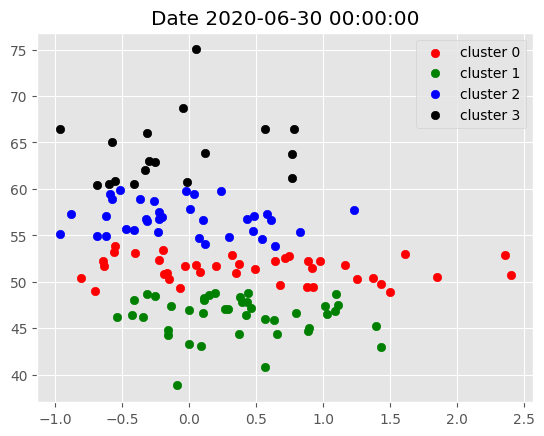

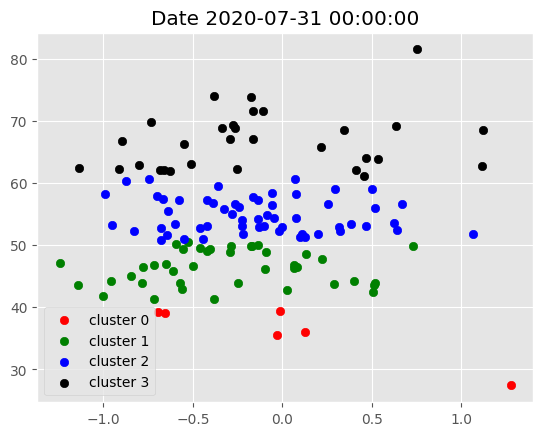

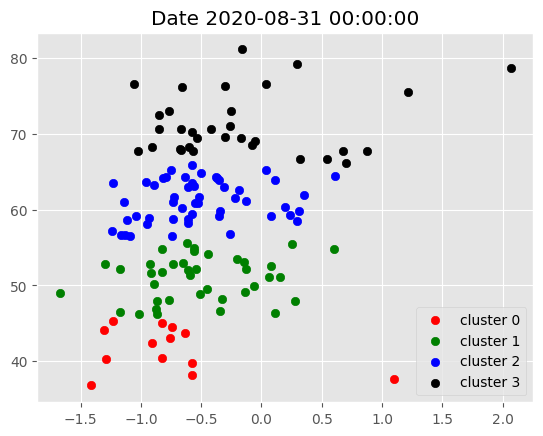

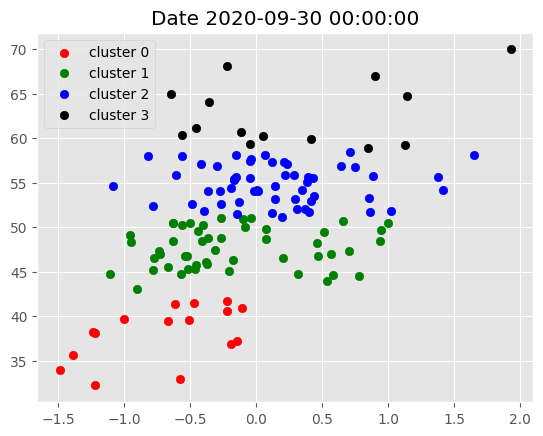

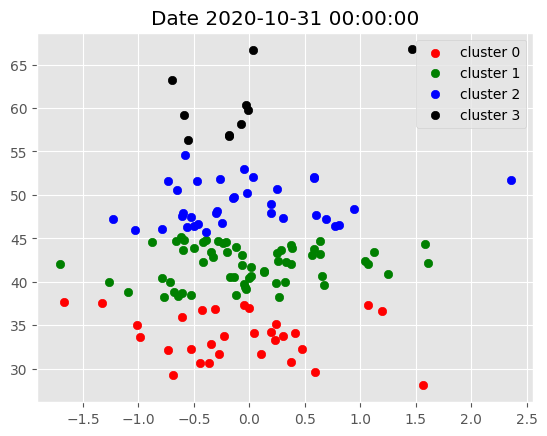

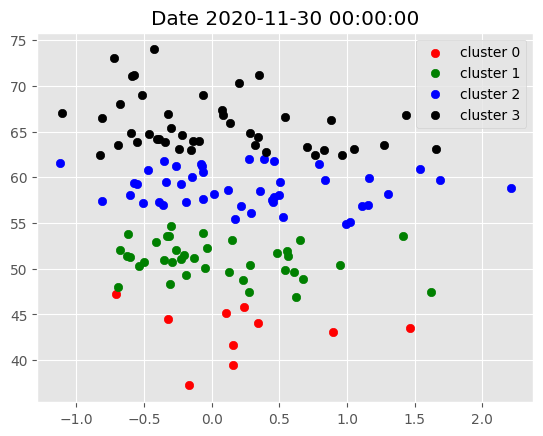

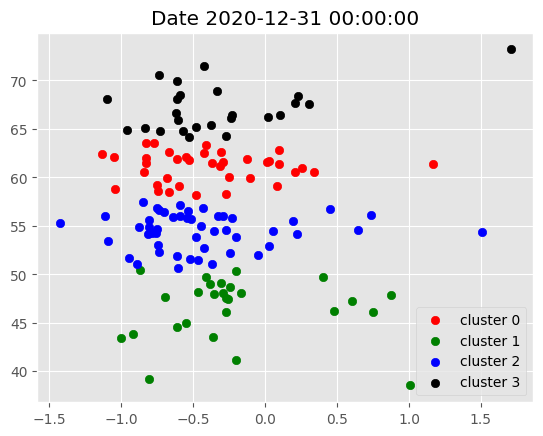

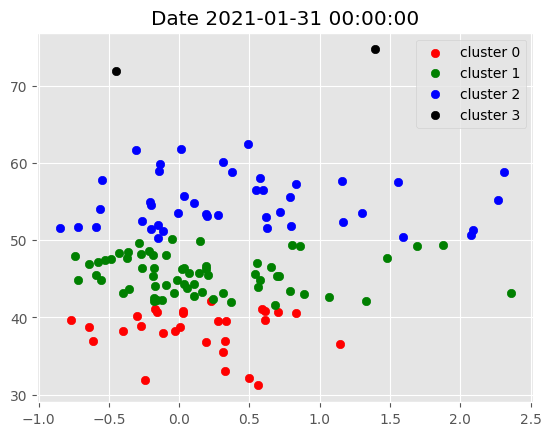

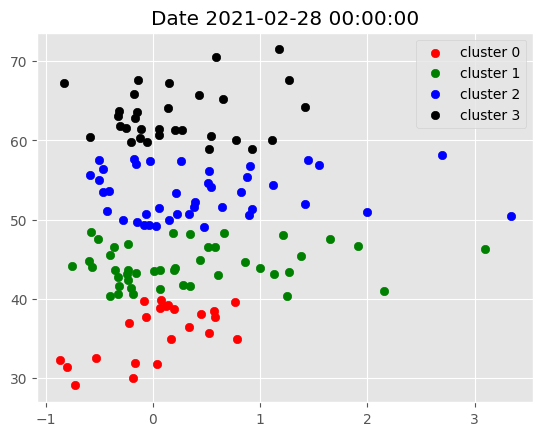

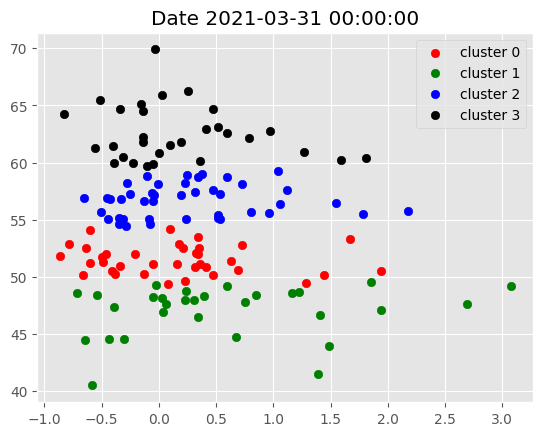

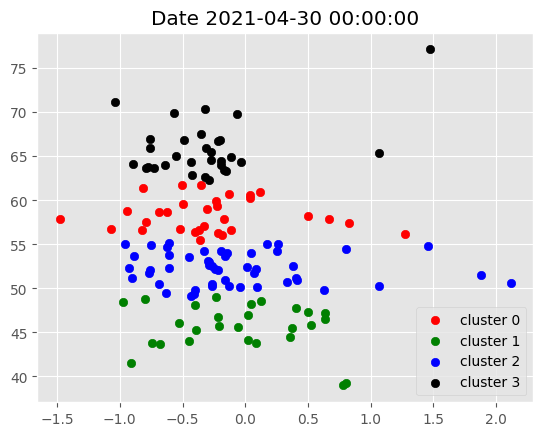

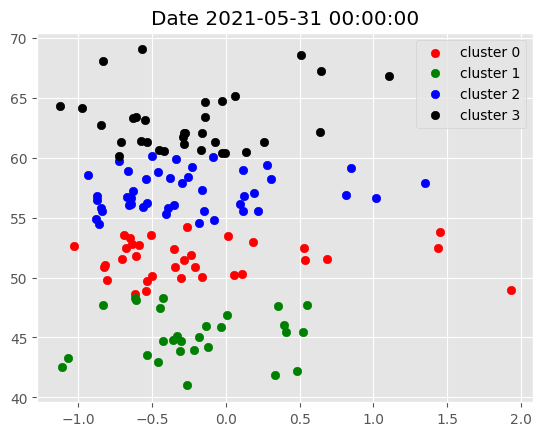

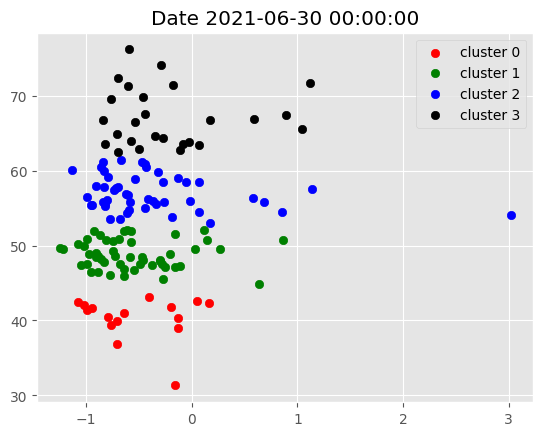

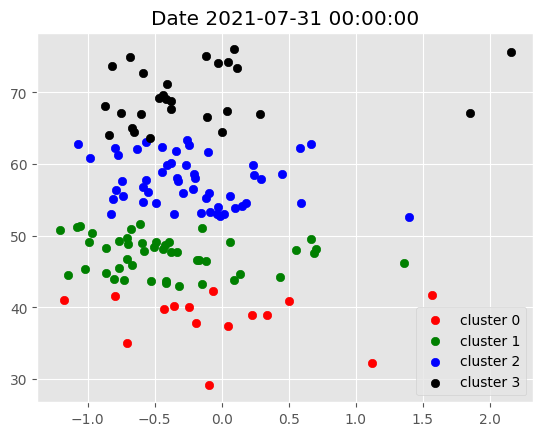

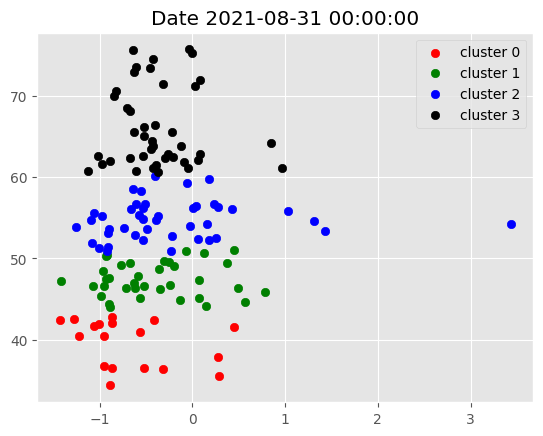

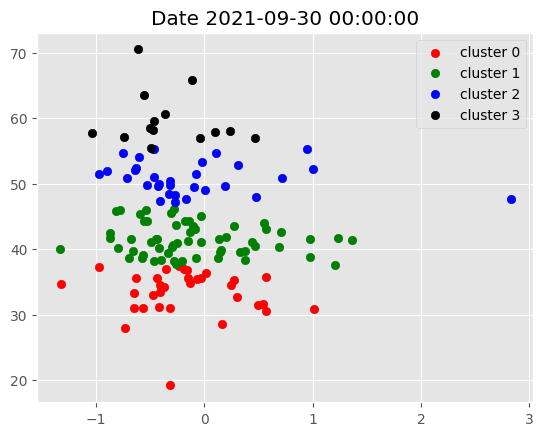

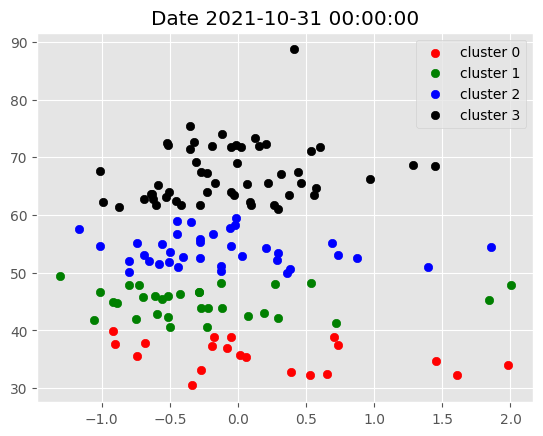

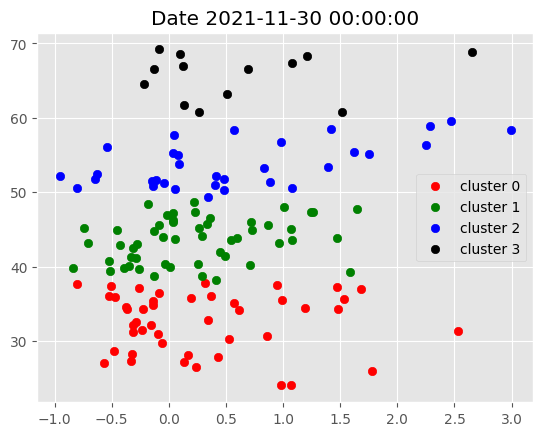

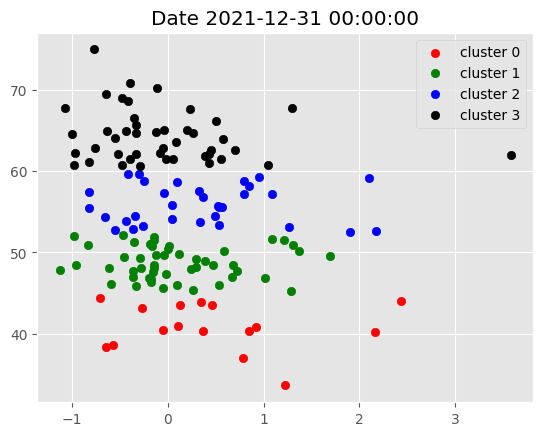

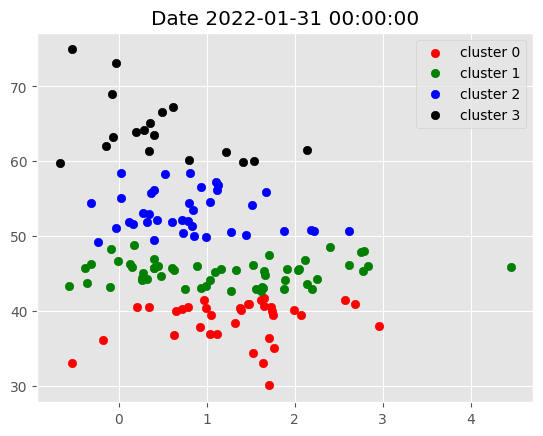

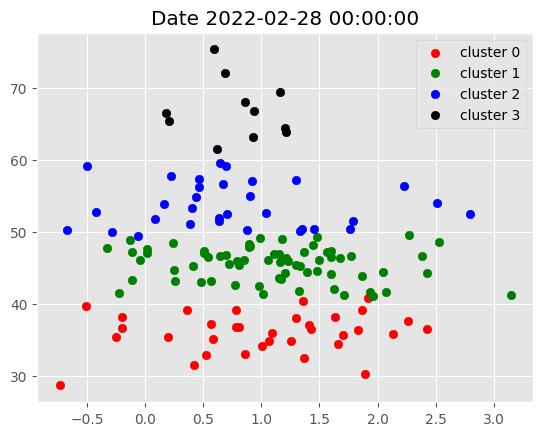

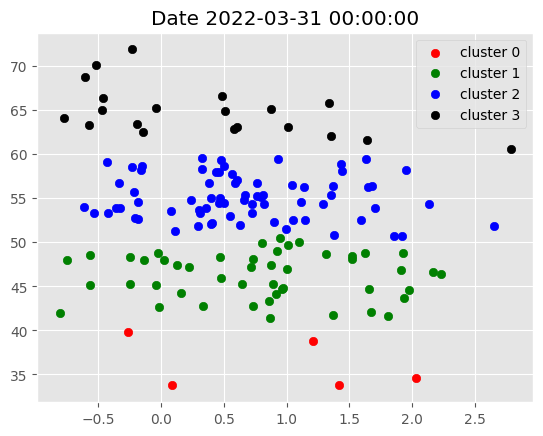

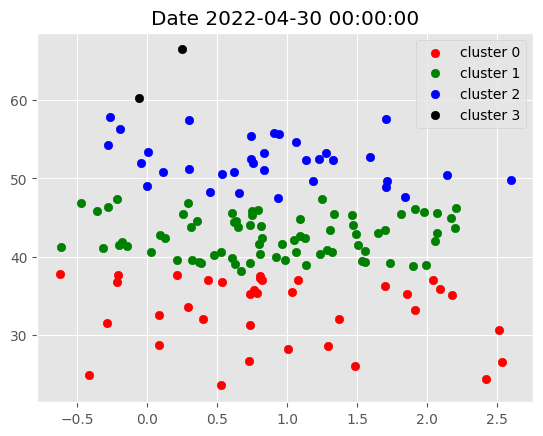

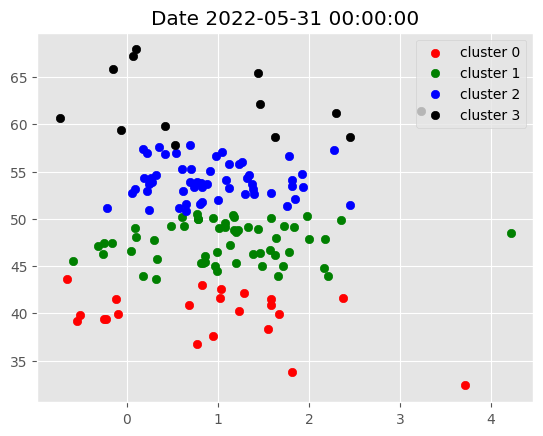

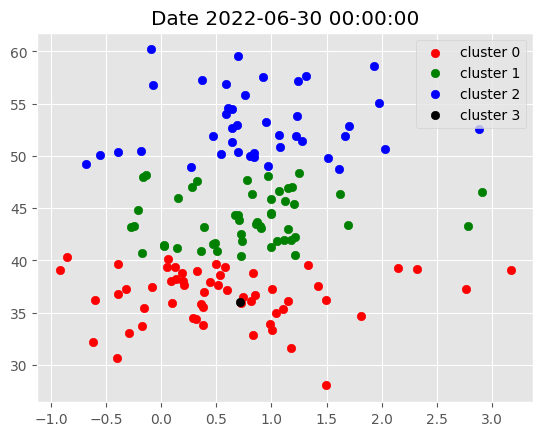

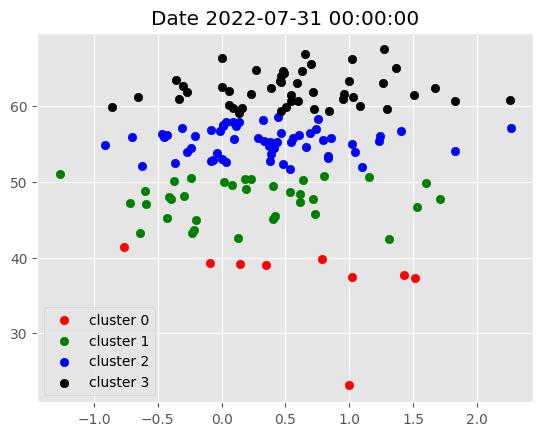

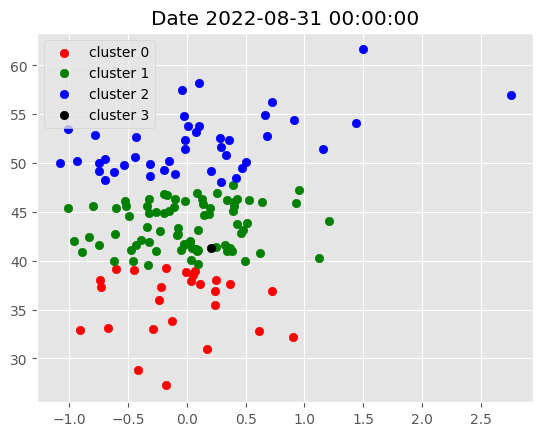

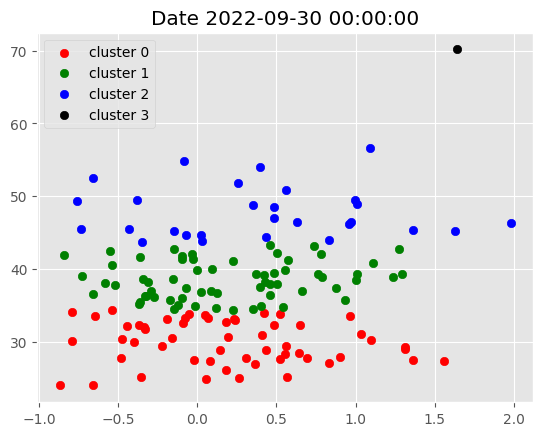

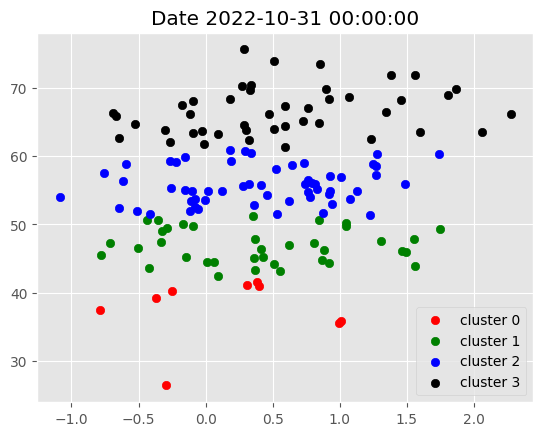

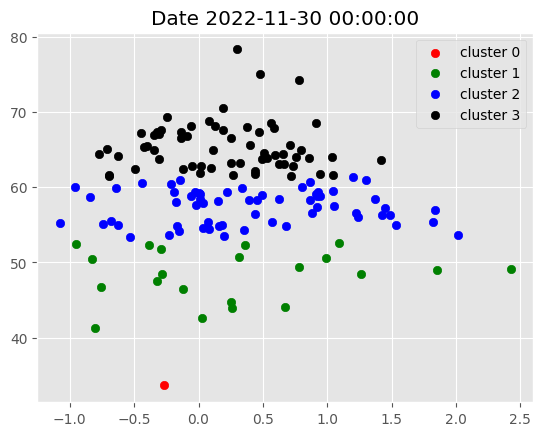

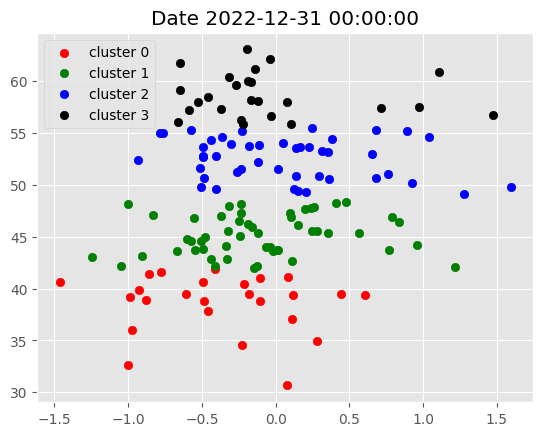

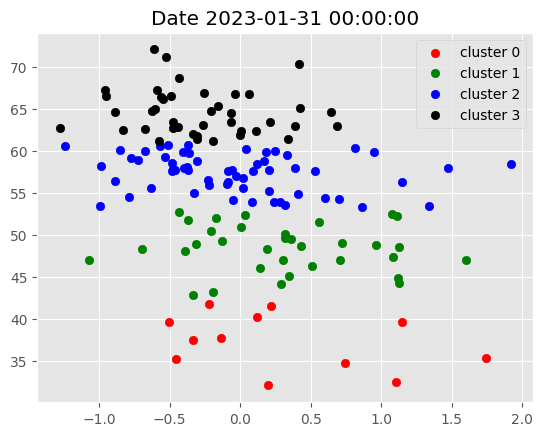

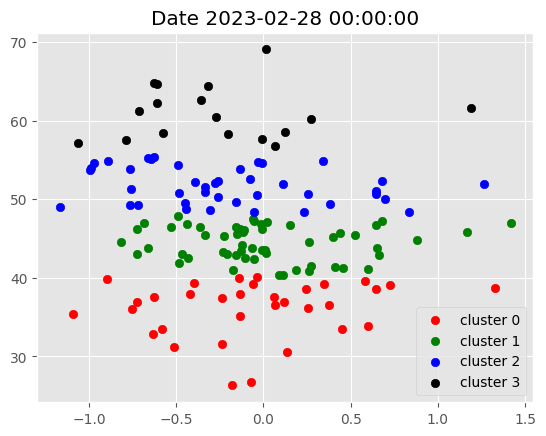

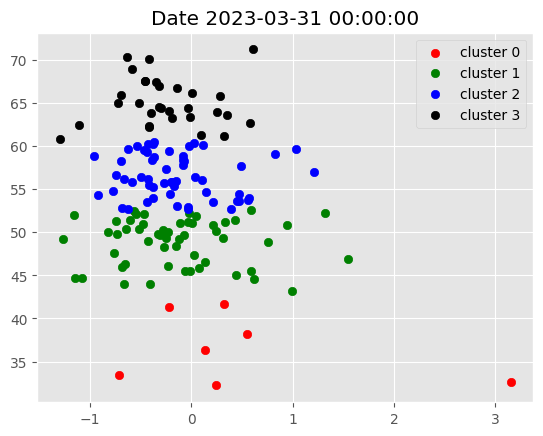

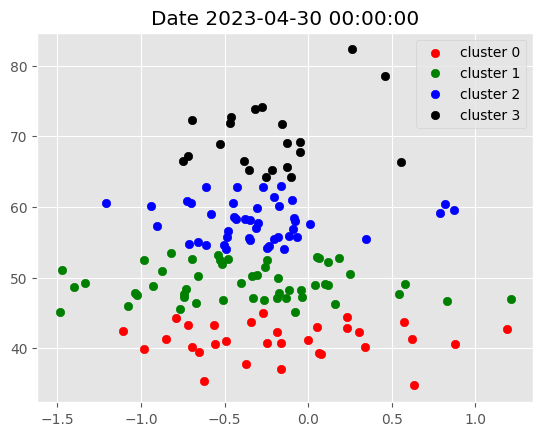

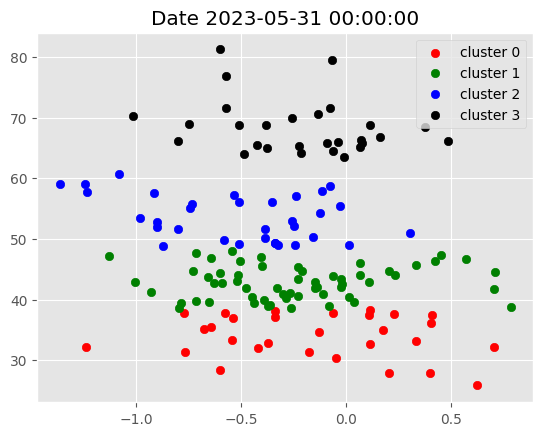

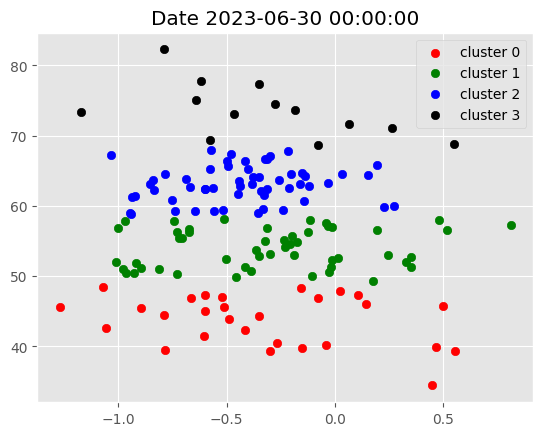

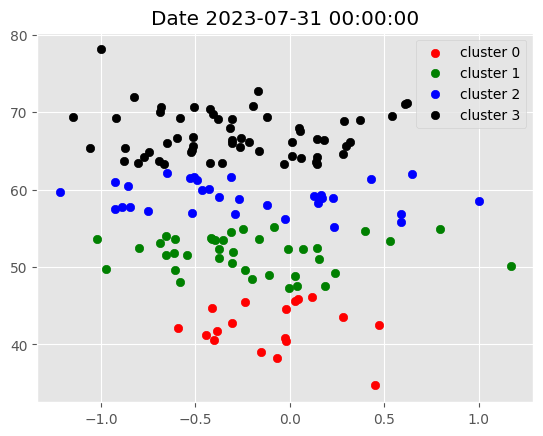

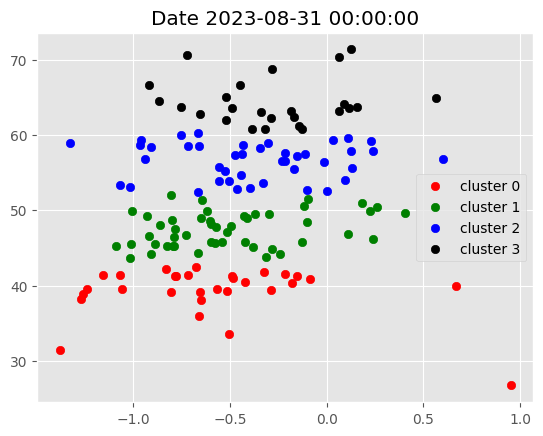

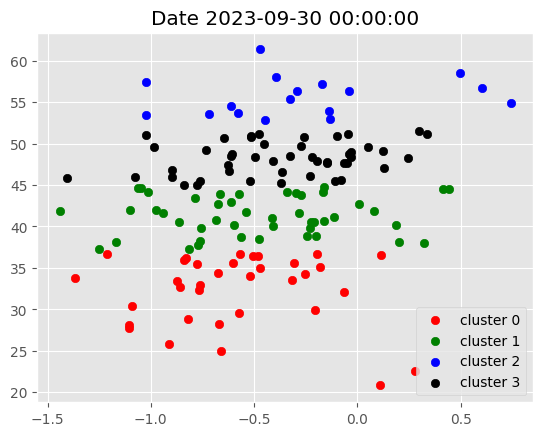

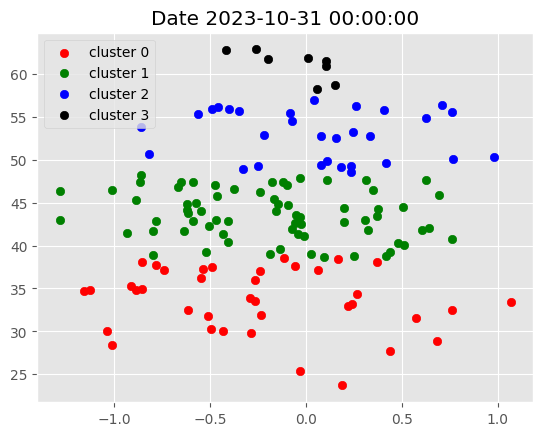

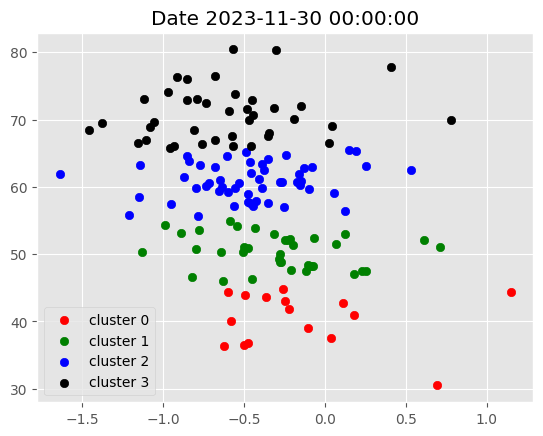

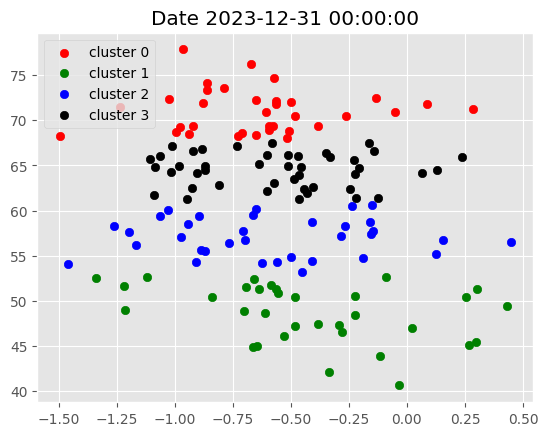

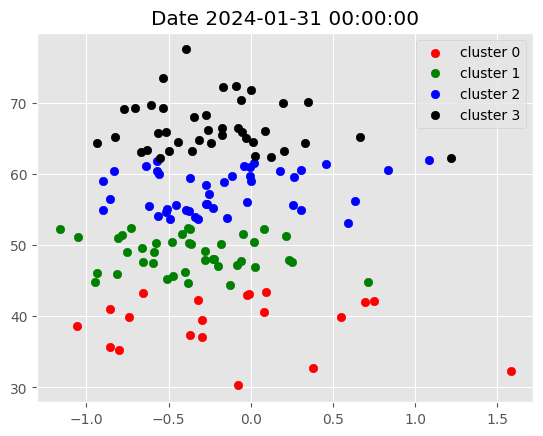

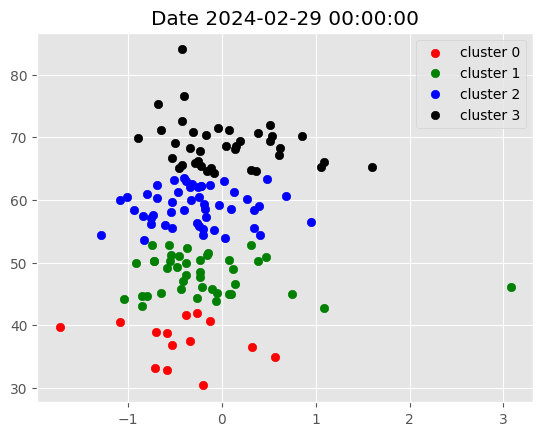

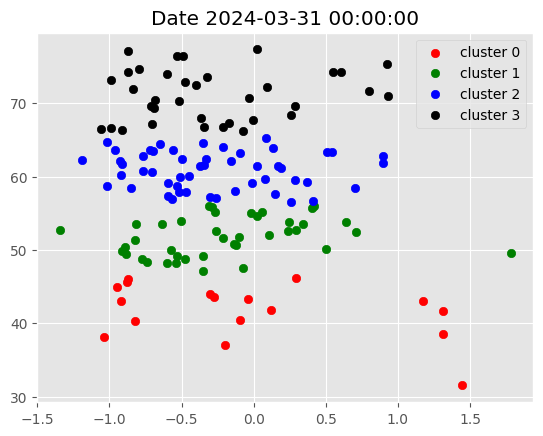

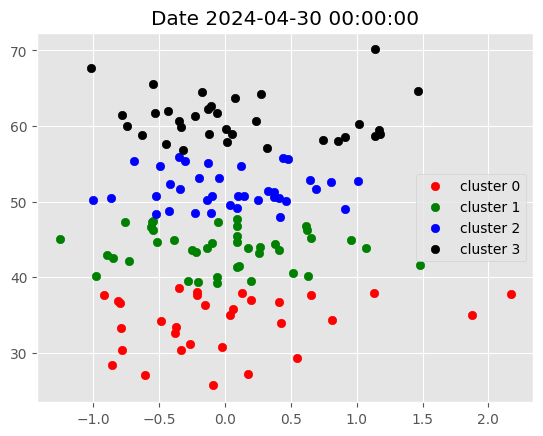

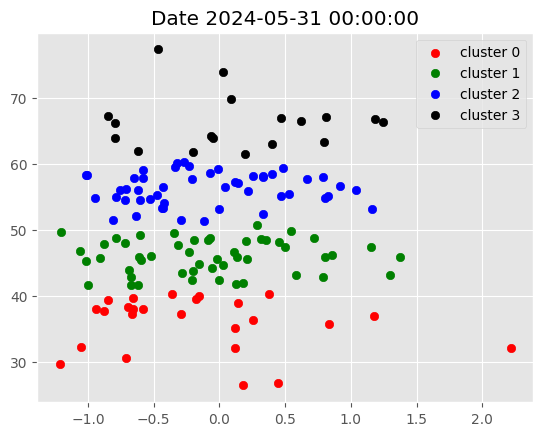

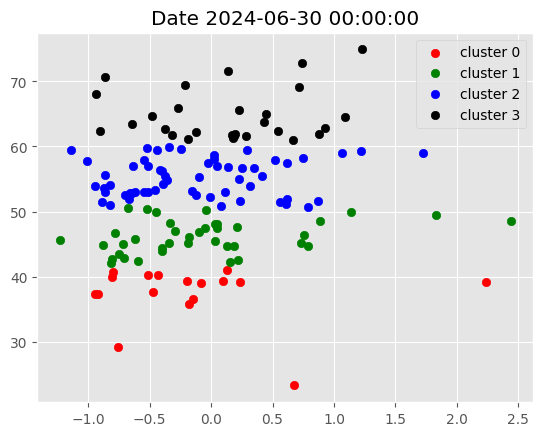

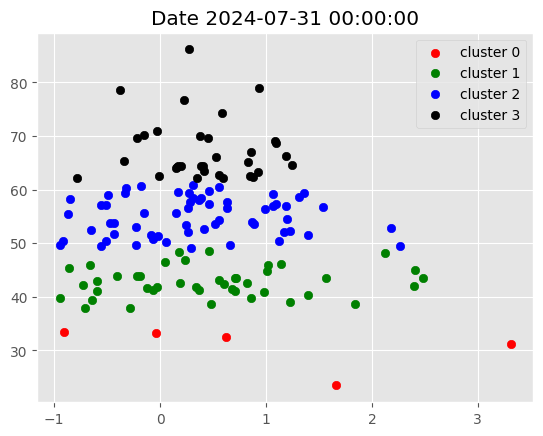

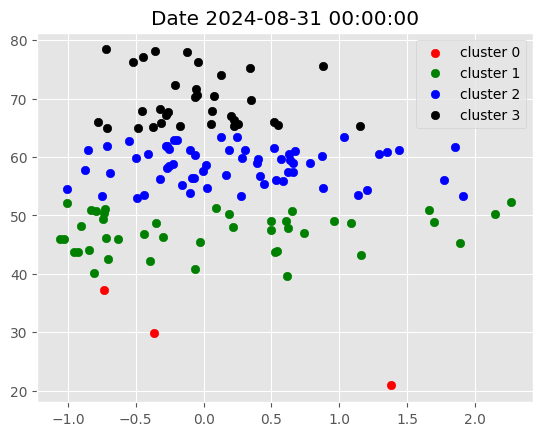

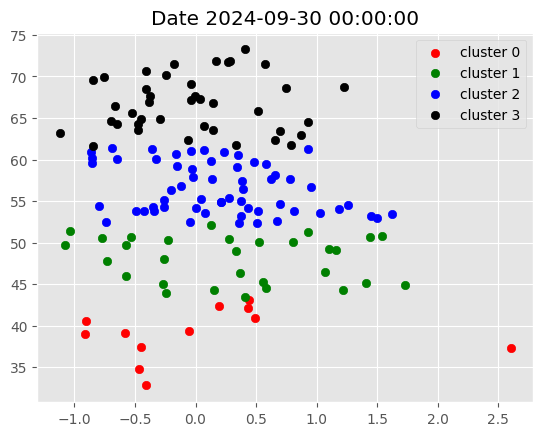

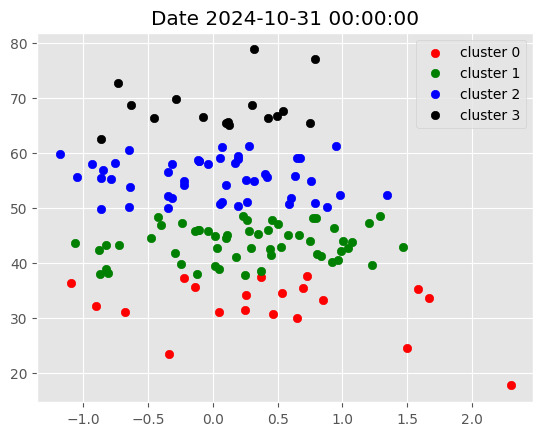

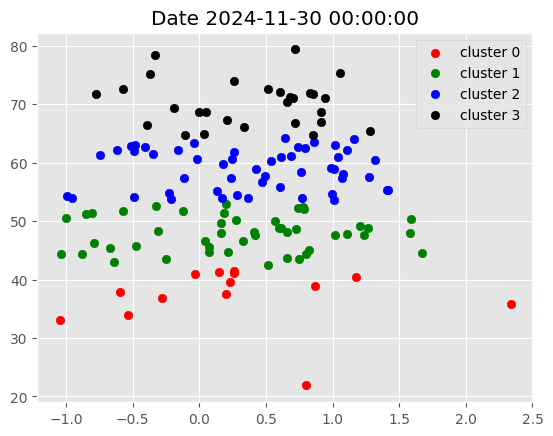

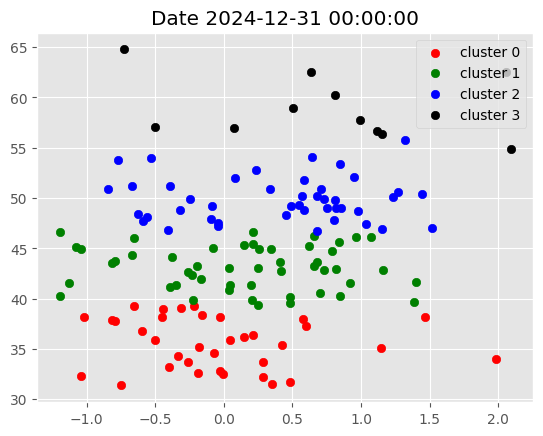

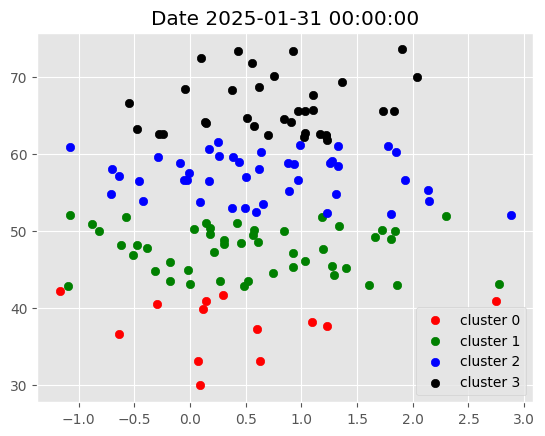

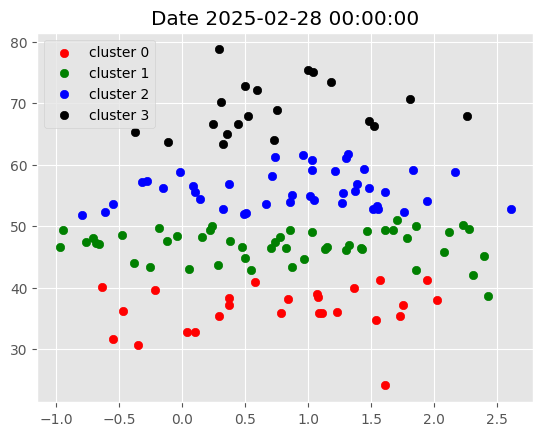

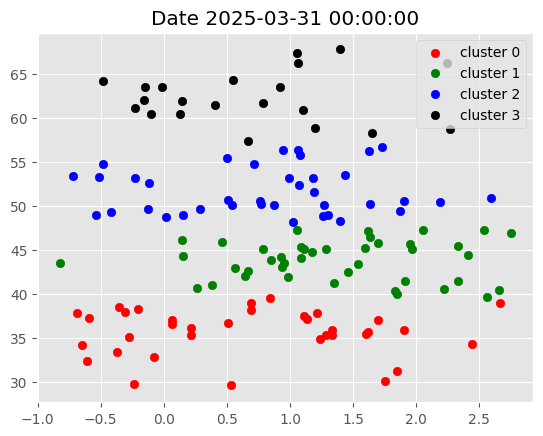

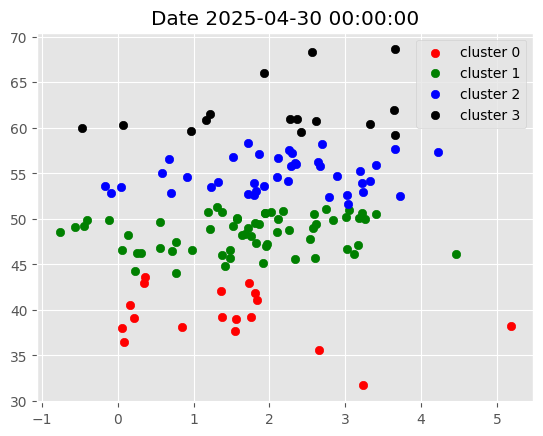

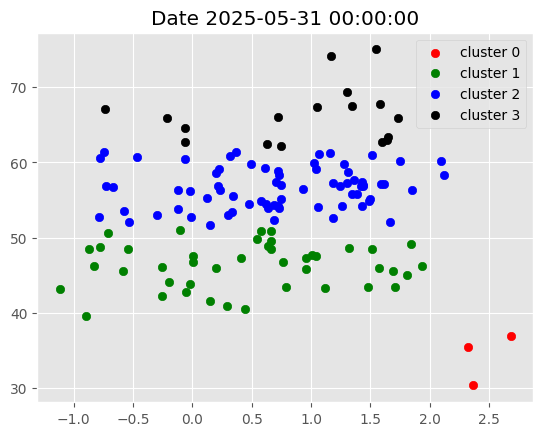

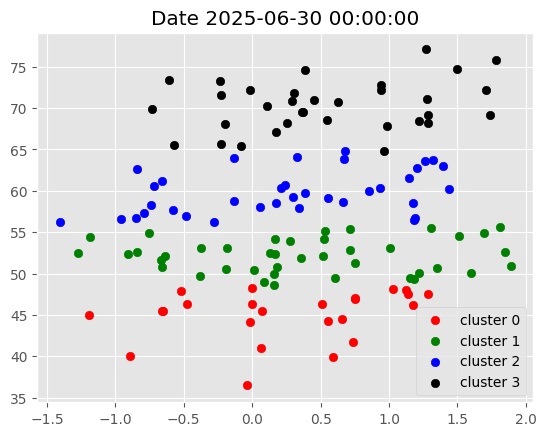

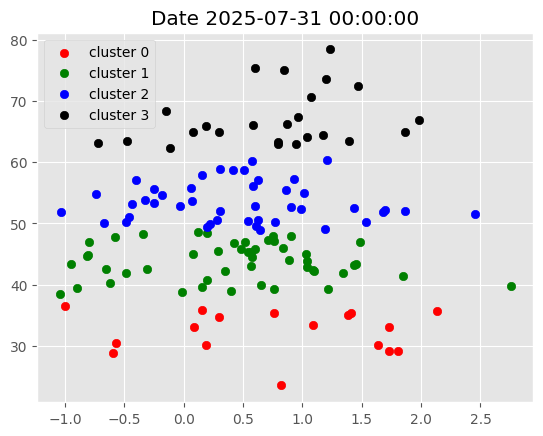

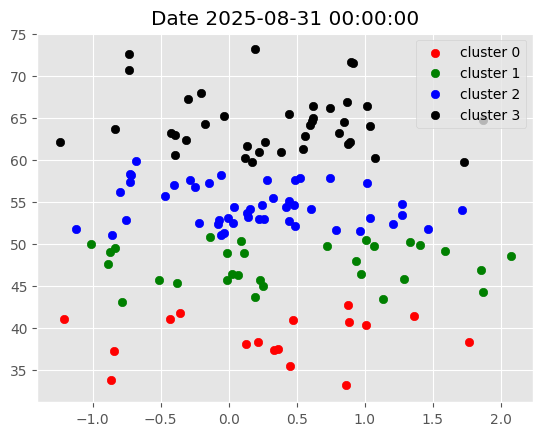

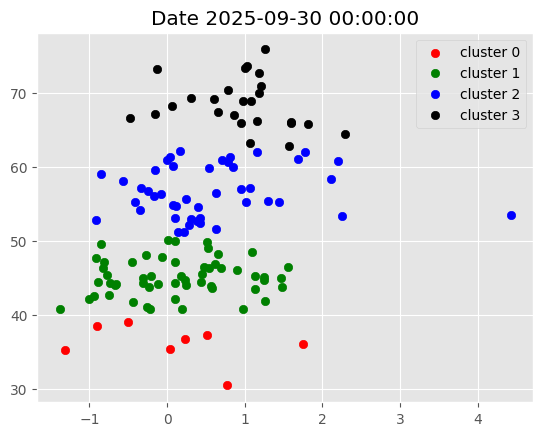

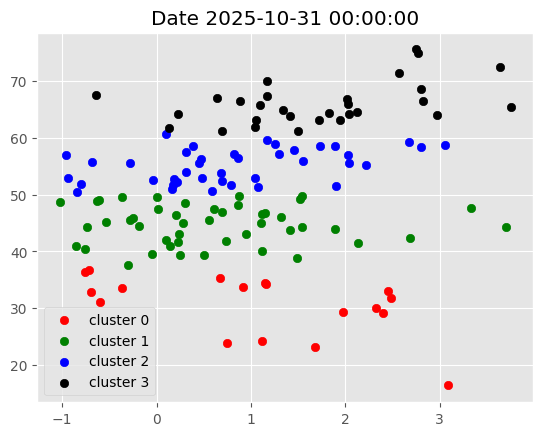

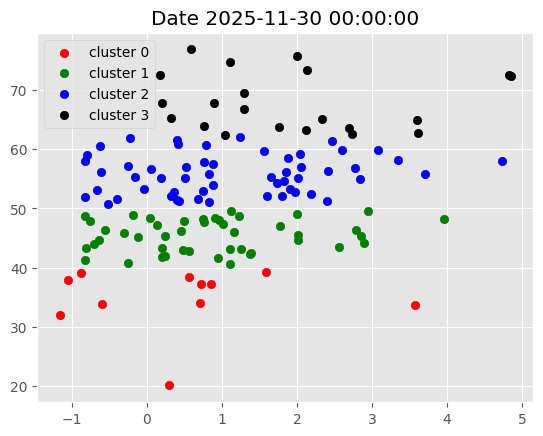

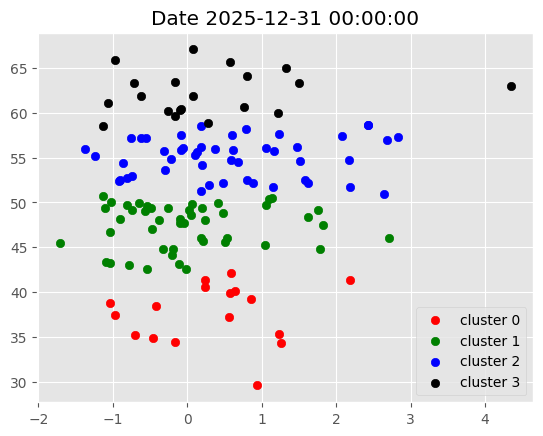

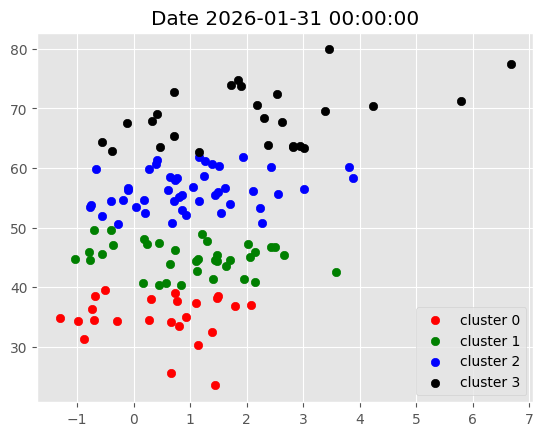

In [171]:
plt.style.use('ggplot')

for i in data.index.get_level_values('Date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')
    
    plot_clusters(g)

#### For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimisation  
- First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.
- Momentum is persistent and the idea would be that stocks clustered around RSI 70 centroud should continue to outperform in the following month - thus we select stocks corresponding to cluster 3

In [184]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['Date', 'Ticker'])

dates = filtered_df.index.get_level_values('Date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2019-04-01': ['AAPL',
  'ACN',
  'ADP',
  'AMT',
  'ANET',
  'AVGO',
  'CMG',
  'COST',
  'CSCO',
  'CSX',
  'HON',
  'INTU',
  'LOW',
  'MA',
  'MCD',
  'MDLZ',
  'MO',
  'MRK',
  'MSFT',
  'NEE',
  'PEP',
  'PG',
  'PYPL',
  'SBUX',
  'TGT',
  'TJX',
  'TMO',
  'ULTA',
  'V'],
 '2019-05-01': ['ACN',
  'ADBE',
  'ADSK',
  'ALGN',
  'AMZN',
  'AXP',
  'BLK',
  'BRK-B',
  'C',
  'CHTR',
  'CMCSA',
  'CSX',
  'DIS',
  'EL',
  'F',
  'HON',
  'JPM',
  'KO',
  'LMT',
  'LRCX',
  'MA',
  'MAR',
  'MCD',
  'MDLZ',
  'META',
  'MS',
  'MSFT',
  'NOW',
  'PEP',
  'PYPL',
  'QCOM',
  'RTX',
  'SBUX',
  'STZ',
  'V'],
 '2019-06-01': ['AMT'],
 '2019-07-01': ['ABT',
  'AMAT',
  'AMGN',
  'AXP',
  'BKNG',
  'BLK',
  'BRK-B',
  'BSX',
  'C',
  'CAT',
  'CHTR',
  'COST',
  'DE',
  'EA',
  'EBAY',
  'EL',
  'GM',
  'GS',
  'HD',
  'HON',
  'LMT',
  'MAR',
  'MCD',
  'MDT',
  'META',
  'MPC',
  'NOC',
  'ORCL',
  'SBUX',
  'SPGI',
  'T',
  'TGT',
  'TMO',
  'V',
  'VLO',
  'WDC',
  'WMT'],
 '2019-08-

#### Define portfolio optimization function  
- We will define a function which optimises weights using PyPortfolioOpt package and EfficientFrontier optimiser to maximise the sharpe ratio.
- To optimise the weights of a given portfolio we would need to supply last 1 year prices to the function.
- Apply single stock weight bounds constrant for diversification (minimum half of equally weight and maximum 10% of portfolio).

In [234]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns

def optimise_weights(prices, lower_bound=0):
  
    returns = expected_returns.mean_historical_return(prices=prices,
                                                          frequency=252 # one year of trading
                                                         )
    
    cov = risk_models.sample_cov(prices=prices,
                                     frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                               cov_matrix=cov,
                               weight_bounds=(lower_bound,0.1), # why?
                               solver='SCS') # whats this?
    
    weights = ef.max_sharpe()
   
    return ef.clean_weights()

In [235]:
stocks = data.index.get_level_values('Ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('Date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('Date').unique()[-1],
                     auto_adjust=False)

new_df

[*********************100%***********************]  154 of 154 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABBV        ABNB         ABT         ACN   
Date                                                                     
2018-04-02   39.194237   64.908714         NaN   50.562195  131.500427   
2018-04-03   39.596352   64.291283         NaN   51.248405  132.220215   
2018-04-04   40.353523   65.959076         NaN   51.647953  133.268799   
2018-04-05   40.633354   65.441002         NaN   51.995422  134.690643   
2018-04-06   39.594002   63.716457         NaN   50.006279  130.967178   
...                ...         ...         ...         ...         ...   
2026-01-26  255.410004  220.770004  133.389999  108.769997  280.709991   
2026-01-27  258.269989  223.929993  132.220001  108.269997  275.799988   
2026-01-28  256.440002  218.669998  131.550003  106.050003  270.429993   
2026-01-29  258.279999  220.429993  131.770004  106.089996  261.220001   
2026-01-30  259.480011  223.009995  129.369995  109.300003  263.640015   

Price                                                                   ...  \
Ticker            ADBE         ADI         ADP        ADSK        ALGN  ...   
Date                                                                    ...   
2018-04-02  212.279999   76.924156   96.197578  122.750000  242.690002  ...   
2018-04-03  215.929993   77.591545   96.825882  124.839996  243.619995  ...   
2018-04-04  225.050003   79.082359   99.101318  127.500000  248.929993  ...   
2018-04-05  223.539993   78.822342   99.772102  128.020004  255.350006  ...   
2018-04-06  218.610001   76.542763   96.537186  125.750000  245.229996  ...   
...                ...         ...         ...         ...         ...  ...   
2026-01-26  304.720001  304.010010  258.170013  272.339996  167.649994  ...   
2026-01-27  297.420013  303.829987  254.509995  268.089996  167.039993  ...   
2026-01-28  299.579987  317.630005  250.690002  268.329987  164.919998  ...   
2026-01-29  291.649994  318.700012  245.970001  255.679993  164.119995  ...   
2026-01-30  293.250000  310.880005  246.820007  252.869995  163.029999  ...   

Price        Volume                                                    \
Ticker          VLO     VRTX         VZ      WDAY       WDC       WFC   
Date                                                                    
2018-04-02  2788500  1804500   16511200   1091800   4504418  23359800   
2018-04-03  2930600  1542300   14841300   1159200   3092645  16646400   
2018-04-04  3659600  1832000   12376400   1863500   3062877  15952700   
2018-04-05  3766300  1352800   13201300   1780500   3069889  16488800   
2018-04-06  3432000  1446300   16071600   1299500   4882796  22943800   
...             ...      ...        ...       ...       ...       ...   
2026-01-26  3370600  1668000   21081800   2473500   7128300  13047400   
2026-01-27  2359800  1631800   26108800   2555600   7483000  15105000   
2026-01-28  2756700  1089100   24412500   3793800  16090500  16395700   
2026-01-29  6555800  1498100   44347500  10129400  15770500  21497000   
2026-01-30  3294900  1190100  123494300   5133000  21648800  18306400   

Price                                              
Ticker           WMT     WYNN       XOM       XYZ  
Date                                               
2018-04-02  57386700  2561200  17891100  11918400  
2018-04-03  29086500  2018900  15999200   9794600  
2018-04-04  19609800  2022200  13122200  10540100  
2018-04-05  19142700  1619600  14200000   9375200  
2018-04-06  19050000  2809600  14299600  14184800  
...              ...      ...       ...       ...  
2026-01-26  19552200  1129100  16056100   5137000  
2026-01-27  22968600   840200  14517000   4546800  
2026-01-28  16342000  1252700  15637300   4927500  
2026-01-29  16381100  2141700  35760600   6381100  
2026-01-30  22202700  1238400  29636900   7232900  

[1970 rows x 924 columns]

- Calculate daily returns for each stock which ould land up in our portfolio.  
- Then loop over reach month start, select the stocks for the month and calculate their weights for the next month.  
- If the maximum sharpe ratio optimisation fails for a given month, apply equally-weighted weights.  
- Calculated each day portfolio return.

Max Sharpe Optimisation failed for 2019-06-01. Continuing with Equal Weights
Max Sharpe Optimisation failed for 2020-03-01. Continuing with Equal Weights
Max Sharpe Optimisation failed for 2020-04-01. Continuing with Equal Weights
Max Sharpe Optimisation failed for 2020-06-01. Continuing with Equal Weights
Max Sharpe Optimisation failed for 2021-02-01. Continuing with Equal Weights
Max Sharpe Optimisation failed for 2022-05-01. Continuing with Equal Weights
Max Sharpe Optimisation failed for 2022-07-01. Continuing with Equal Weights
Max Sharpe Optimisation failed for 2022-09-01. Continuing with Equal Weights
Max Sharpe Optimisation failed for 2022-10-01. Continuing with Equal Weights
Max Sharpe Optimisation failed for 2023-11-01. Continuing with Equal Weights
'return'


<Axes: xlabel='date'>

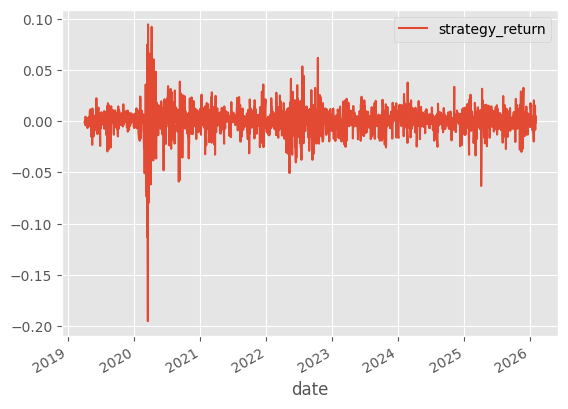

In [286]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    
        cols = fixed_dates[start_date] # stocks for each month that we use in our portfolio
    
        # to get the optmisation, we need one year prior data to the start date
        # so we use new_df for that
    
        optimisation_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        
        optimisation_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimisation_df = new_df[optimisation_start_date:optimisation_end_date]['Adj Close'][cols]
    
        success = False
    
        try:
    
            weights = optimise_weights(prices=optimisation_df, 
                                       lower_bound=round(1/(len(optimisation_df.columns)*2), 3))
        
            weights = pd.DataFrame(weights, index=pd.Series(0))
    
            success = True
        except:
            print(f'Max Sharpe Optimisation failed for {start_date}. Continuing with Equal Weights')
            
        if success==False:
            weights = pd.DataFrame([1/len(optimisation_df.columns) for _ in range(len(optimisation_df.columns))],
                                    index=optimisation_df.columns.tolist(),
                                    columns=pd.Series(0)).T
        temp_df = returns_dataframe[start_date:end_date]
        
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                         .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                                left_index=True,
                                right_index=True)\
                         .reset_index().set_index(['Date', 'Ticker']).unstack().stack()
    
        temp_df.index.names = ['date', 'ticker']
    
        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
    
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('strategy_return')
    
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df.plot()

### Visualise Portfolio returns and compare to SP500 returns

In [287]:
spy = yf.download(tickers='SPY',
                  start='2019-01-01',
                  end=dt.date.today(),
                  auto_adjust=False).stack().droplevel(1)

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close': 'SPY Buy&Hold'}, axis=1)


portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


strategy_return  SPY Buy&Hold
date                                     
2019-04-01        -0.000847      0.011789
2019-04-02        -0.001391      0.000490
2019-04-03         0.000626      0.001572
2019-04-04        -0.003659      0.002650
2019-04-05         0.004582      0.004829
...                     ...           ...
2026-01-26        -0.000736      0.005065
2026-01-27         0.015440      0.003976
2026-01-28        -0.002030     -0.000101
2026-01-29         0.005575     -0.001986
2026-01-30        -0.007271     -0.002987

[1719 rows x 2 columns]

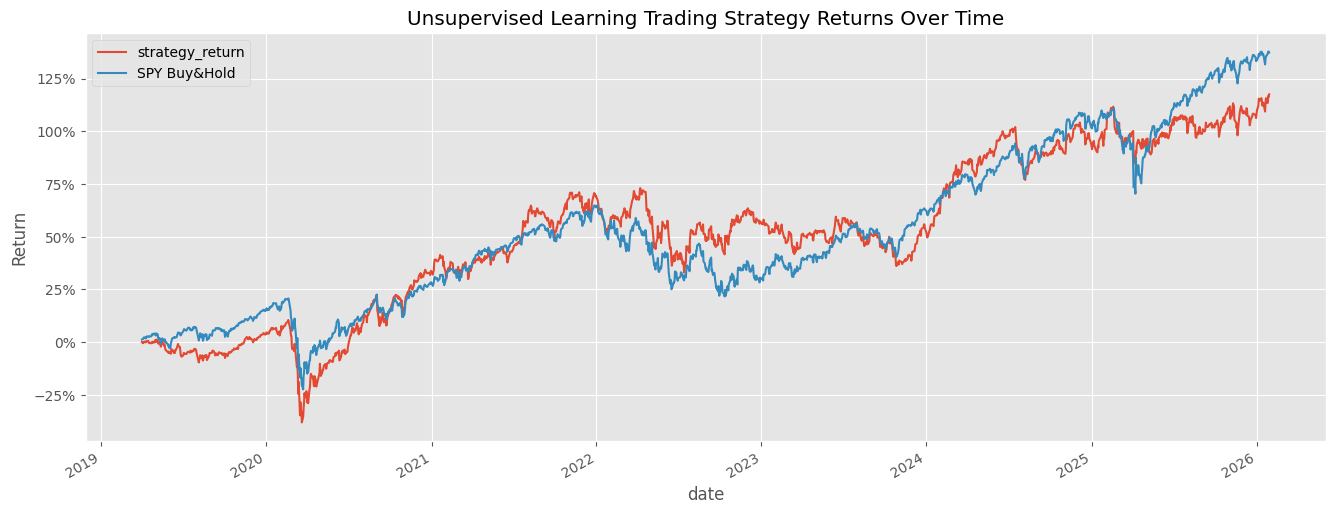

In [293]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2026-01-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.ylabel('Return')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()